In [ ]:
from dotenv import load_dotenv
import os
import nomics
from pprint import pprint as pp
import json
from time import sleep


# initialize the environment
load_dotenv()
API_KEY=os.getenv("API_KEY")

nom = nomics.Nomics(API_KEY)
# get list of currencies
# rates = nom.ExchangeRates.get_rates()

pp(nom.Candles.get_candles(currency='BTC', interval='1h'))
# pp(rates)

In [25]:
# put currencie names in a list
currencies = []
for currency in rates:
    currencies.append(currency['currency'])

# get name for each currency
cryptos = {}
dead_cryptos = []
living_cryptos = []
INTERVALS = [1,3,5,7]
intervals_s = map(lambda x: str(x) + 'd', INTERVALS)

for currency in currencies:
    cryptos[currency] = {}
    response = nom.Currencies.get_currencies(ids=currency,interval=','.join(intervals_s))
    sleep(1)
    # pp(response)
    if response != []:
        cryptos[currency]['name'] = response[0]['name']
        cryptos[currency]['status'] = response[0]['status']
        cryptos[currency]['volume']= list(zip(INTERVALS, map(lambda x: response[0][x]['volume'], intervals_s)))
        # pp(cryptos)
        living_cryptos.append(currency)
    else:
        dead_cryptos.append(currency)


        

[]
[]
[]
[]
[]
[]
[]
[{'1d': {'market_cap_change': '289720069.38',
         'market_cap_change_pct': '0.0351',
         'price_change': '1.01915375',
         'price_change_pct': '0.0349',
         'volume': '571556494.91',
         'volume_change': '182731593.58',
         'volume_change_pct': '0.4700'},
  '30d': {'market_cap_change': '-1483406635.18',
          'market_cap_change_pct': '-0.1479',
          'price_change': '-5.44925471',
          'price_change_pct': '-0.1527',
          'volume': '23271215267.46',
          'volume_change': '-20965197145.69',
          'volume_change_pct': '-0.4739'},
  '365d': {'market_cap_change': '7241720139.73',
           'market_cap_change_pct': '5.5400',
           'price_change': '24.75595964',
           'price_change_pct': '4.5173',
           'volume': '415804253349.53',
           'volume_change': '331889996459.71',
           'volume_change_pct': '3.9551'},
  '7d': {'market_cap_change': '-345099441.35',
         'market_cap_change_pct': 

In [45]:
from dotenv import load_dotenv
import os
import nomics
from pprint import pprint as pp
import json
from time import sleep
import pandas as pd
import requests
import io
from collections import OrderedDict
from copy import deepcopy

# initialize the environment
load_dotenv()
API_KEY=os.getenv("API_KEY")

nom = nomics.Nomics(API_KEY)

# get CSV of currencies
request_url = f'https://api.nomics.com/v1/prices?key={API_KEY}&format=csv'
with requests.Session() as s:
    download=s.get(request_url)
    decoded_content = download.content.decode('utf-8')
    cr = pd.read_csv(io.StringIO(decoded_content),names=['currency_id', 'price'])

currency_ids = cr['currency_id'].tolist()
i = 0
sleep(1)

# Yield successive n-sized
# chunks from l.
def divide_chunks(l, n):
    # looping till length l
    for i in range(0, len(l), n): 
        yield l[i:i + n]

# Return the place in the list of returned data where the requested currency is located.
# -1 if not found.
def get_currency_index(currency_id: str, result: list) -> int:
    for i, currency in enumerate(result):
        if currency['id'] == currency_id:
            return i
    return -1

CHUNK_SIZE=100
currency_ids_chunked = list(divide_chunks(currency_ids, CHUNK_SIZE))
currency_data_dict = OrderedDict()
COLUMNS = ['status', 'name', 'market_cap', 'circulating_supply', 'volume', 'rank', 'high', 'high_timestamp', 'num_exchanges']

for currency_chunk in currency_ids_chunked:
    response = nom.Currencies.get_currencies(ids=','.join(currency_chunk))
    
    sleep(1.1)
    i+=CHUNK_SIZE
    if i%500 == 0:
        print(f'{i}/{len(currency_ids)}')
    for currency in currency_chunk:
        # data_update = ['currency_status', 'currency_name', 'market_cap']
        data_update = []
        try:
            currency_index = get_currency_index(currency, response)
            # print(f'Currency Index for {currency} is {currency_index}')
            for column in COLUMNS:
                if currency_index == -1:
                    # currency not found in response from nomics
                    data_update.append('dead')
                else:
                    data_update.append(response[currency_index].get(column, '0'))
        except AttributeError as e:
            data_update.append('redo')
            print(f'{currency} is dead')
        currency_data_dict[currency] = deepcopy(data_update)
        
print('finished currency status analysis')

currency_update_df = pd.DataFrame.from_dict(currency_data_dict, orient='index', columns=COLUMNS)
currency_update_df.reset_index(inplace=True)
currency_update_df.rename(columns={'index':'currency_id'}, inplace=True)

combined_df = pd.merge(cr, currency_update_df, on='currency_id')


500/12203
1000/12203
1500/12203
2000/12203
2500/12203
3000/12203
3500/12203
4000/12203
4500/12203
5000/12203
5500/12203
6000/12203
6500/12203
7000/12203
7500/12203
8000/12203
8500/12203
9000/12203
9500/12203
10000/12203
10500/12203
11000/12203
11500/12203
12000/12203
finished currency status analysis


In [46]:
pp(combined_df.head())

  currency_id     price  status               name market_cap  \
0       0XBTC  1.764247  active          0xBitcoin   14092189   
1        0XCX  0.906010  active  0x (Currency.com)          0   
2       0XGAS  3.606124  active            P2P Gas          0   
3   1000KISHU  0.000003  active         1000 KISHU          0   
4   1000SHIB2  0.037597  active           1000SHIB          0   

  circulating_supply volume  rank            high        high_timestamp  \
0            7987650      0   700      4.09446073  2018-06-06T00:00:00Z   
1                  0      0  8050      1.32674000  2021-11-11T00:00:00Z   
2                  0      0  6733      9.86257187  2020-12-04T00:00:00Z   
3                  0      0  6790  0.000015122493  2021-05-15T00:00:00Z   
4                  0      0  2268     0.056696761  2021-11-11T00:00:00Z   

  num_exchanges  
0            15  
1             1  
2             2  
3             1  
4             2  


In [80]:
print(combined_df.dtypes)

currency_id            object
price                 float64
status                 object
name                   object
market_cap             object
circulating_supply     object
volume                 object
rank                   object
high                   object
high_timestamp         object
num_exchanges          object
dtype: object


In [82]:
import numpy as np

df = combined_df.astype({'currency_id': str,
    'price': float,
    'status': 'category',
    'name': str,
    'market_cap': float,
    'circulating_supply': float,
    'volume': float,
    'rank': int,
    'high': float,
    'high_timestamp': np.datetime64,
    'num_exchanges': int},errors='ignore')
# combined_df['high_timestamp'] = pd.to_datetime(combined_df['high_timestamp'])
# combined_df['status'] = combined_df['status'].astype('category')
pp(df['market_cap'].describe())

count    1.220300e+04
mean     2.015708e+08
std      9.925173e+09
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      9.475632e+11
Name: market_cap, dtype: float64


<AxesSubplot:>

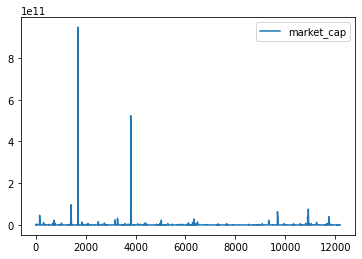

In [71]:
market_cap_filtered.plot.line(y='market_cap')

In [70]:
market_cap_filtered = pd.DataFrame(df[df['market_cap'] > 0]['market_cap']).sort_index(1, ascending=False)
market_cap_filtered.describe()


C:\Users\Gamer\AppData\Local\Temp/ipykernel_18128/2090280290.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_index will be keyword-only
  market_cap_filtered = pd.DataFrame(df[df['market_cap'] > 0]['market_cap']).sort_index(1, ascending=False)


,market_cap
count,1.840000e+03
mean,1.336831e+09
std,2.553628e+10
min,2.500000e+01
25%,5.543098e+05
50%,4.455455e+06
75%,5.558270e+07
max,9.475632e+11


<AxesSubplot:>

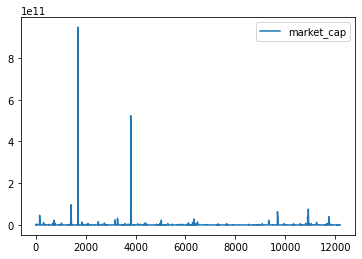

In [78]:
len(market_cap_filtered)
market_cap_filtered.plot(kind='line', y='market_cap')

In [84]:
print(df.dtypes)


currency_id             object
price                  float64
status                category
name                    object
market_cap             float64
circulating_supply     float64
volume                 float64
rank                     int32
high                   float64
high_timestamp          object
num_exchanges            int32
dtype: object


In [85]:
df.to_pickle('..\\downloaded_data\\nomics\\crypto_data.pkl')

In [86]:
test_df = pd.read_pickle('..\\downloaded_data\\nomics\\crypto_data.pkl')

In [87]:
test_df.head()

,currency_id,price,status,name,market_cap,circulating_supply,volume,rank,high,high_timestamp,num_exchanges
0,0XBTC,1.764247,active,0xBitcoin,14092189.0,7987650.0,0.0,700,4.094461,2018-06-06T00:00:00Z,15
1,0XCX,0.906010,active,0x (Currency.com),0.0,0.0,0.0,8050,1.326740,2021-11-11T00:00:00Z,1
2,0XGAS,3.606124,active,P2P Gas,0.0,0.0,0.0,6733,9.862572,2020-12-04T00:00:00Z,2
3,1000KISHU,0.000003,active,1000 KISHU,0.0,0.0,0.0,6790,0.000015,2021-05-15T00:00:00Z,1
4,1000SHIB2,0.037597,active,1000SHIB,0.0,0.0,0.0,2268,0.056697,2021-11-11T00:00:00Z,2


In [7]:
import pandas as pd
currency = 'BTC'
currency_data = pd.read_pickle(
        f"..\\downloaded_data\\nomics\\candles\\{currency}.pkl"
    )

In [9]:
type(currency_data)

pandas.core.frame.DataFrame

In [1]:
my_list = ['$$$', '000', '0XECH', '0XESV', '0XETC', '0XETD', '0XETH', '0XK', '0XMKR', '1000SHIB', '10MT', '10U', '1111', '13213', '1667591279645C', '1950', '1951', '1952', '1953', '1955', '1956', '1AI', '1BIT', '1CHAD', '1CN', '1DAO', '1ECO', '1FLY', '1MC', '1ML', '1PT', '1UP2', '22', '2DAO1C', '3MY', '3RATEPLUS', '3TT', '401K', '420DAO', '420T', '501C', '50CB', '66', '6892S', '69C', '69DAO', '7MLA', '8848', '8888U', 'A500', 'AA', 'AAAAA', 'AAAVE', 'AAGVENTURES', 'AAHP', 'AAMMBPTBALWETH', 'AAMMBPTWBTCWETH', 'AAMMDAI', 'AAMMUNIAAVEWETH', 'AAMMUNIBATWETH', 'AAMMUNICRVWETH', 'AAMMUNIDAIUSDC', 'AAMMUNIDAIWETH', 'AAMMUNILINKWETH', 'AAMMUNIMKRWETH', 'AAMMUNIRENWETH', 'AAMMUNISNXWETH', 'AAMMUNIUNIWETH', 'AAMMUNIUSDCWETH', 'AAMMUNIWBTCUSDC', 'AAMMUNIWBTCWETH', 'AAMMUNIYFIWETH', 'AAMMUSDC', 'AAMMUSDT', 'AAMMWBTC', 'AAMMWETH', 'AAMPL', 'AAPL', 'AARON', 'AART', 'AB520', 'ABAL', 'ABAT', 'ABATV2', 'ABCDAO', 'ABD', 'ABELETRUST', 'ABELLCOIN', 'ABF', 'ABLD', 'ABN', 'ABOT', 'ABPT', 'ABSCHAIN', 'ABSR', 'ABTK', 'ABULL', 'ABUSDV2', 'AC2', 'AC32', 'AC4', 'AC7', 'ACABDAO', 'ACAR', 'ACC2', 'ACCD', 'ACCF', 'ACCO', 'ACE2', 'ACE3', 'ACEPAY', 'ACF', 'ACH2', 'ACID2', 'ACLT', 'ACMD', 'ACN2', 'ACOIN3', 'ACP', 'ACRV', 'ACS2', 'ACU2', 'ACY', 'ADAMOON2', 'ADAN', 'ADC2', 'ADDTOKEN', 'ADIDASNFT', 'ADLER', 'ADMTOKEN', 'ADNB', 'ADO', 'ADTT', 'ADVP', 'ADX2', 'ADZUKI', 'AEGISDAO', 'AENJ', 'AENJV2', 'AES2', 'AEST', 'AETH2', 'AEUR', 'AFARM', 'AFC2', 'AFCASHBEP20', 'AFCX', 'AFDT', 'AFEES', 'AFFYN', 'AFRICA', 'AFRO2', 'AFRT', 'AGAIN', 'AGDN', 'AGE', 'AGGRO', 'AGL3', 'AGN', 'AGNCX', 'AGNI', 'AGOL', 'AGOS', 'AGS2', 'AGU2', 'AGUSD', 'AHF', 'AI', 'AIBE', 'AIDAO', 'AIGOPAY', 'AIM2', 'AINU', 'AINU2', 'AIPP', 'AIRBUD', 'AIREP', 'AIRIN', 'AIRSHIB', 'AIRSHIBA', 'AISHIB', 'AIU', 'AIVA', 'AK47DAO', 'AKASHA', 'AKEMASHI', 'AKEMASHIINU', 'AKEMI', 'AKINU', 'AKITA2', 'AKITAGOOSE', 'AKITAXL', 'AKNC', 'AKNCV2', 'AKO', 'ALA2', 'ALA4', 'ALB2', 'ALBA', 'ALBINU', 'ALC3', 'ALD2', 'ALE', 'ALEND', 'ALEXDOGE', 'ALG2', 'ALGOPAD', 'ALICEF', 'ALIENKIBA', 'ALIENX', 'ALL2', 'ALL3', 'ALLCOIN', 'ALLINU', 'ALLSESAME', 'ALLUO', 'ALMN', 'ALOK', 'ALP2', 'ALPA2', 'ALPACA2', 'ALPH', 'ALPHABIT', 'ALPHACITY', 'ALPHACON', 'ALPHAXPH', 'ALR', 'ALTE', 'ALTI', 'ALXO', 'ALZA', 'AMANA', 'AMANAV2', 'AMC2', 'AMGO', 'AMINU', 'AMIS2', 'AMIX', 'AMKR', 'AMKRV2', 'AMNZ', 'AMPLE', 'AMRITA', 'AMRSHA', 'AMS2', 'AMWBTC', 'AMX', 'AMZ2', 'AMZ3', 'ANDAO', 'ANDINA', 'ANDROMEDA', 'ANG2', 'ANGELBNB', 'ANGORA', 'ANGRYDUCK', 'ANIME', 'ANK2', 'ANN2', 'ANNA', 'ANOM', 'ANONDOGE', 'ANONYMUS', 'ANSO', 'ANTA', 'ANTI', 'ANTIJINDOGE', 'ANTIKP3R', 'ANTIRUG', 'ANTISHAPPY', 'ANTIVAX', 'ANTS2', 'ANYUSDT', 'AOCODS', 'AON', 'AOOKIES', 'APA', 'APAY', 'APE', 'APE4', 'APECAPITAL', 'APEGIRL', 'APEIR', 'APELAND', 'APELP', 'APEUSDAAVEDEC21', 'APEUSDLINKDEC21', 'APEUSDSNXDEC21', 'APEUSDUMADEC21', 'APEUSDUNIDEC21', 'APH2', 
'API2', 'APING', 'APIS2', 'APO', 'APOLLO2', 'APPN', 'APS', 'APSC', 'APT2', 'APX2', 'AQP', 'AQUAXLM', 'ARABCOIN', 'ARAI2', 'ARBETH', 'ARBIS', 'ARBITSHIBA', 'ARCANEINU', 'ARCANEJINX', 'ARCEE', 'ARCELON', 'ARCHI', 'ARCXOLD', 'ARD', 'AREN', 'ARENV2', 'AREP', 'ARES', 'AREX', 'ARL', 'AROPA', 'ARP', 'ART2', 'ARTCN', 'ARTDECO', 'ARTEM', 'ARVM', 'AS', 'ASAMI', 'ASET', 'ASETH', 'ASGC', 'ASHIB2', 'ASHIBAM', 'ASLAN', 'ASMRDAO', 'ASNXV2', 'ASOBI', 'ASP', 'ASP2', 'ASSHOL', 'AST3', 'ASTAR', 'ASTRO7', 'ASTRODO', 'ASUSDV2', 'ATB2', 'ATC2', 'ATHENA', 'ATLANTICO', 'ATMC', 'ATMN', 'ATMOS', 'ATNMY', 'ATOM3BEAR', 'ATOM3BULL', 'ATOMPERP', 'ATRIX', 'ATRON', 'ATS4', 'ATT4', 'ATUSD', 'ATUSDV2', 'AU2', 'AU21CD', 'AUC2', 'AUCT', 'AUDCX', 'AUDI', 'AUK', 'AUNI', 'AUPC', 'AUS2', 'AUSDT', 'AUST', 'AUTOXRP', 'AUX2', 'AVABIRD', 'AVAF', 'AVAG', 'AVAPOP', 'AVAX3BEAR', 'AVAX3BULL', 'AVAXIOU', 'AVAXSUMMIT', 'AVCLA', 'AVG2', 'AVIT', 'AVL', 'AVT2', 'AWBTC', 'AWBTC2', 'AWC2', 'AWDPLUS', 'AWI', 'AWKWRD', 'AXIV', 'AXN', 'AXSCQ', 'AXSM', 'AXSUSHI', 'AXTR', 'AXUS', 'AYFI1', 'AYS', 'AZERO', 'AZERSWAP', 'AZG', 'AZIZ', 'AZNC', 'AZO', 'AZRX', 'AZRXV2', 'AZTEC', 'B', 'B0NE', 'B21X', 'B2TMOON', 'B3', 'BAASTOKEN', 'BABY88888', 'BABY98X', 'BABYALIEN', 'BABYBUTTER', 'BABYCATGIRL', 'BABYCGAR', 'BABYCLIFF', 'BABYCOB', 'BABYCOBRA', 'BABYCORGIS', 'BABYCQ', 'BABYDINGER', 'BABYDOGE5', 'BABYEAG', 'BABYETHQ', 'BABYFLOKIDOGE', 'BABYFLOKIINU', 'BABYFLOKIV2', 'BABYGAME', 'BABYGOCHI', 'BABYGOOSE', 'BABYGUH', 'BABYHARMONY', 'BABYHONEYBADGER', 'BABYHONEYBEE', 'BABYHT', 'BABYHTCQ', 'BABYINU', 'BABYKATA', 'BABYKIBA', 'BABYKIRBY', 'BABYKORI', 'BABYKORIINU', 'BABYKSU', 'BABYKUNO', 'BABYLEO', 'BABYLUNAFOX', 'BABYMDEX', 'BABYMETA', 'BABYMONGOOSE', 'BABYNAMI', 'BABYNARUTO', 'BABYPANDA', 'BABYPARIS', 'BABYPINU', 'BABYPUNK', 'BABYRAIN', 'BABYREFI', 'BABYROBOSHIB', 'BABYSHAKI', 'BABYSHIBURAI', 'BABYSOS', 'BABYUNI2', 'BABYVOLT', 'BABYVPAD', 'BABYWOLVERINU', 'BAC2', 'BADBOY', 'BADS', 'BAGB', 'BAKA', 'BAKI', 'BAKITA', 'BALHEDGE', 'BALLERX', 'BALT', 'BAND3BEAR', 'BAND3BULL', 'BANDIT', 'BANELON', 'BANKSY', 'BANQ', 'BANTO', 'BAQ', 'BARCELONA', 'BARD', 'BARTBONK', 'BASECHAIN', 'BASEDGOOSE', 'BASEV2', 'BASTION', 'BATCAT', 'BATCOIN', 'BATDOGE', 'BATDOGE3', 'BATU', 'BAY3', 'BBBM', 'BBCD', 'BBDG', 'BBDR', 'BBE2', 'BBF', 'BBG', 'BBGOOSE', 'BBI2', 'BBMG', 'BBNV', 'BBOMB', 'BBQDOG', 'BBR3', 'BBT2', 'BBTOKEN', 'BBX2', 'BCAT2', 'BCCF', 'BCCS', 'BCES', 'BCHNRBTCJAN2021', 'BCINU', 'BCK', 'BCM2', 'BCOINS', 'BCR3', 'BCTERMINAL', 'BCU', 'BCURVE', 'BCZ2', 'BD', 'BDCDAO', 'BDCM', 'BDEM', 'BDI', 'BDK2', 'BDOGE4', 'BDR', 'BDSM', 'BDX2', 'BDX3', 'BDXR', 'BEAN2', 'BEAST', 'BEAV', 'BEB', 'BEEFY', 'BEETR', 'BEIK', 'BEN2', 'BENTLEY', 'BEP20', 'BEPLP', 'BERT', 'BET3', 'BETFTY', 'BETH2', 'BETH3', 'BETS2', 'BETY', 'BEX', 'BEXTTRC20', 'BFAV', 'BFC4', 'BFDT', 'BFEG', 'BFF', 'BFF1', 'BFF2', 'BFI4', 'BFINU', 'BFIST', 'BFL', 'BFORCE', 'BFT2', 'BFX2', 'BG', 'BG2', 'BGB', 'BGC3', 'BGCC', 'BGD', 'BGG2', 'BGR', 'BGS', 'BGX2', 'BHBT', 'BHEX', 'BHINU', 'BHOLE', 'BHOT', 'BHSL', 'BHTD', 'BIB', 'BIBLEF', 'BIC2', 'BICA', 'BICCOIN', 'BID2', 'BID3', 'BIDF', 'BIFF', 'BIGBULLCOIN', 'BIGD', 'BIGMOONER', 'BIGSTEALTH', 'BIKA', 'BIL', 'BILI', 'BIN5', 'BINANCECOIN', 'BINOSAURS', 'BINPAY', 'BINS', 'BIO2', 'BIO3', 'BIRD6', 'BISCUIT', 'BISER', 'BISOU', 'BITBUSINESSCOIN', 'BITBYBIT', 'BITCF', 'BITFX', 'BITFXT', 'BITMONEY', 'BITNBEP20', 'BITNETCOIN', 'BITO', 'BITONION', 'BITPAID', 'BITRICE', 'BITSOU', 'BITTOKENECONOMY', 'BITTREXCOIN', 'BITVALUTA', 'BITWIRES', 'BIUBA', 'BIX1901', 'BJ', 'BJD', 'BJOE', 'BK', 'BKC3', 'BKF2', 'BKFMEME', 'BKINGBEP20', 'BKJUN', 'BKN', 'BKRX', 'BLACKGOOSE', 'BLACKHOLES', 'BLACKPANTHER', 'BLATOKEN', 'BLAZE2', 'BLD', 'BLDF', 'BLDOG', 'BLE', 'BLEC', 'BLEM', 'BLF', 'BLH', 'BLM', 'BLOCKCHAINTOAPPLICATION', 'BLOCKID', 'BLOCKNODE', 'BLOCKONIXTOKEN', 'BLOCKPLUS', 'BLOCS', 'BLOKPAD', 'BLONDCOIN', 'BLONDI', 'BLOXCHAIN', 'BLST', 'BLT1', 'BLUEBERRY2', 'BLVD', 'BLXM', 'BLZ2', 'BLZ3BEAR', 'BLZ3BULL', 'BMB2', 'BMC2', 'BMCT', 'BMDAO', 'BMEX', 'BMGCHI', 'BMJ', 'BMN', 'BMT3', 'BMTOKEN', 'BMV1', 'BMVT', 'BMWS', 'BMXTOKEN', 'BNB3BEAR', 'BNB3BULL', 'BNB50', 'BNBC2', 'BNBCQ', 'BNBG', 'BNBQ', 'BNFIST', 'BNFT', 'BNL', 'BNOW', 'BNSTAR', 'BNT2', 'BNTE', 'BNV2', 'BNWG', 'BNX2', 'BOA2', 'BOARDCOIN', 'BOB3', 'BOB4', 'BOBBS', 'BOBCAT', 'BOBOSHIB', 'BOBT', 'BOBTAIL', 'BOBUX', 'BOCA', 'BOCAI', 'BOGA', 'BOHM', 
'BOK', 'BOLA', 'BOLT2', 'BOLTERC20', 'BON2', 'BONAINU', 'BONB', 'BONE4', 'BONES', 'BONES2', 'BONKYAVAX', 'BONNY', 'BONU', 'BOOCAKE', 'BOOGLE', 'BOOKS', 'BOOM2', 'BOOMCOIN', 'BOOMERSENATORKAREN', 'BOOMY', 'BOREAL', 'BOREDKORIINU', 'BORN', 'BOSS2', 'BOSS3', 'BOSSY', 'BOST2', 'BOT3', 'BOT4', 'BOTC', 'BOTTON', 'BOUNCY', 'BOWSER', 'BP3', 'BPAD', 'BPAK9', 'BPC2', 'BPC3', 'BPC4', 'BPT2', 'BPYTC', 'BRA', 'BRAN', 'BRAVE2', 'BRBG', 'BREAD', 'BREATH', 'BRI2', 'BRIA', 'BRIAN', 'BRIB', 'BRIDOG', 'BRL3', 'BRUTO', 'BRV', 'BRWL', 'BRWN', 'BRX2', 'BSAP', 'BSB', 'BSC2', 'BSCM2E', 'BSCTOKEN', 'BSD3', 'BSE2', 'BSE3', 'BSKR', 'BSN2', 'BSS', 'BST1', 'BST2', 'BSTC', 'BSUD', 'BSVPERP', 'BT1', 'BT5', 'BTC3BEAR', 'BTC3BULL', 'BTC3L2', 'BTC3S2', 'BTC4BEAR', 'BTC4BULL', 'BTC5BEAR', 'BTC5BULL', 'BTCALPHA', 'BTCBRAVAX', 'BTCBRCRO', 'BTCBRERC20', 'BTCBRFTM', 'BTCBRFUSE', 'BTCBRHARMONY', 'BTCBRHOO', 'BTCBRHRC20', 'BTCBRKCC', 'BTCBRKIP20', 'BTCBRMOVR', 'BTCBRXDAI', 'BTCC2', 'BTCCASHCLASSIC', 'BTCCLASSICTOKEN', 'BTCCROWN', 'BTCD', 'BTCD2', 'BTCETHP', 'BTCG2', 'BTCLSK', 'BTCM2', 'BTCM3', 'BTCMOON', 'BTCNB', 'BTCNEO', 'BTCNEWYORK', 'BTCT2', 'BTCT3', 'BTCTRC20', 'BTCU2', 'BTCUSDCRSI2', 'BTCUSDCTA2', 'BTCWH', 'BTCZILLA', 'BTDOGE', 'BTE2', 'BTED', 'BTG2', 'BTGE', 'BTGN', 'BTH2', 'BTH3', 'BTHJ', 'BTJL', 'BTL2', 'BTMXHALF', 'BTNC', 'BTNYX', 'BTO2', 'BTP2', 'BTPAY', 'BTR2', 'BTRFLY', 'BTRN2', 'BTS2', 'BTTR2', 'BTTS', 'BTV2', 'BTV3', 'BTV4', 'BTVS', 'BTW2', 'BTWTY', 'BTY', 'BUC2', 'BUDDY', 'BUDS', 'BUFFDOGE', 'BUGA', 'BUGR', 'BUILDER', 'BUILDTEAM', 'BULLBEARBTCSETII', 'BULLDAO', 'BULLDOG', 'BULLDOG2', 'BULLGOOSE', 'BULLMOON', 'BULLTANG', 'BULLYINU', 'BULT', 'BUNNY4', 'BUNNY5', 'BUNNYGIRL', 'BUNNYINU', 'BUNNYZILLA', 'BUNOINU', 'BUR2', 'BURGERAPES', 'BURNR', 'BURNT', 'BURNTOKEN', 'BURNX', 'BURNY', 'BUSD2', 'BUSDSTABLE', 'BUSDT', 'BUSY', 'BUTCH', 'BUTT', 'BUZ', 'BUZZ2', 'BVITALIK', 'BVS', 'BWC', 'BWT2', 'BXSHU', 'BYAKKO', 'BYB', 'BYK', 'BYSC', 'BYT2', 'BYTC', 'BYTE', 'BYTE2', 'BYTE3', 'BYTEXTOKEN', 'BYTSBEP20', 'BZRX3L', 'BZRX3S', 'C11ATTLE', 'C3P', 'CABO', 'CABO2', 'CACAO', 'CACH', 'CACXT', 'CAD2', 'CADAC', 'CADCX', 'CAE', 'CAHAT', 'CAKEDEX', 'CAKEPAYDAY', 'CAKEPUNKS', 'CALO', 'CALVIN', 'CAMEL', 'CAMI', 'CAMO2', 'CAN2', 'CAN3', 'CANDY3', 'CANDY6', 'CANDYBALL', 'CANDYDOGE', 'CANNA', 'CAP2', 'CAPCOIN', 'CAPP2', 'CAPRA', 'CAPTAINSHIB', 'CAPTRC20', 'CAR', 'CAR2', 'CAREERCOIN', 'CARLOS', 'CAROT', 'CARS', 'CARX', 'CAS4', 'CASEY', 'CASHPOKERPRO', 'CASPR', 'CASTER', 'CASTWEET', 'CAT3', 'CATCTI', 'CATDOGE', 'CATEONE', 'CATINBOOTS', 'CATKAGE', 'CATNIP', 'CATORAI', 'CATPR', 'CATS6', 'CATURN', 'CATURNV2', 'CAUCOIN1', 'CAUCOIN10', 'CAUCOIN11', 'CAUCOIN12', 'CAUCOIN13', 'CAUCOIN14', 'CAUCOIN15', 'CAUCOIN16', 'CAUCOIN17', 'CAUCOIN18', 'CAUCOIN19', 'CAUCOIN2', 'CAUCOIN21', 'CAUCOIN22', 'CAUCOIN23', 'CAUCOIN24', 'CAUCOIN3', 'CAUCOIN5', 'CAUCOIN7', 'CAUCOIN9', 'CAVEHERMITINU', 'CAVIAR', 'CAY', 'CAY2', 'CBC2', 'CBC3', 'CBC7', 'CBCCOIN', 'CBCD', 'CBDAO', 'CBI', 'CBK2', 'CBNT', 'CBR2', 'CBRDOG', 'CBT2', 'CBT3', 'CBTC2', 'CC2', 'CCA2', 'CCAI', 'CCASH', 'CCC10', 'CCC3', 'CCD', 'CCDIV', 'CCI', 'CCKK', 'CCN2', 'CCN4', 'CCOIN', 'CCPT2', 'CCTC2', 'CCURVE', 'CCVT', 'CCX3', 'CCY2', 'CDAO', 'CDE', 'CDF2', 'CDG', 'CDJ', 'CDNB', 'CDOT', 'CDRONE', 'CDS4', 'CDX2', 'CDY', 'CEFS', 'CELEB2', 'CENTRIC', 'CERE', 'CESHU', 'CETH2', 'CFCDAO', 'CFS', 'CFT4', 'CGC2', 'CGET', 'CGIZA', 'CGR', 'CGT2', 'CGUARDS', 'CH50CX', 'CHANE', 'CHAPO', 'CHARGE', 'CHAT2', 'CHATBIT', 'CHCH', 'CHE3', 'CHEEMIES', 'CHEEMISTRY', 'CHEEMSKING', 'CHEETAH', 'CHEETAHINU', 'CHEEZ', 'CHER', 'CHERRYCUBE', 'CHESS3', 'CHI3', 'CHIBA3', 'CHICKS', 'CHIEF', 'CHIIINU', 'CHILDREN', 'CHILI', 'CHIM', 'CHIMB', 'CHINCHILLA', 'CHINLUCK', 'CHIPMUNK', 'CHIRO', 'CHJ', 'CHLO', 'CHMC', 'CHOW2', 'CHOWINU', 'CHRIS', 'CHRISTINU', 'CHRISTMASDREAM', 
'CHRISTMASPARTY', 'CHRISTMASTIGER', 'CHRISTSHIB', 'CHS3', 'CHT4', 'CHT5', 'CHT6', 'CHUNGE5', 'CHUNGHOPTOKEN', 'CHUPA', 'CHXC', 'CHZERC20', 'CIM2', 'CINOBI', 'CINU', 'CIP', 'CIRCL', 'CITEXFUNDTOKEN', 'CKDAO', 'CKM', 'CKZ70', 'CLAP', 'CLAUS', 'CLAYMORE', 'CLEI', 'CLG2', 'CLIFF', 'CLIFFFLOKI', 'CLIFFLOL', 'CLIFFLON', 'CLIFFORK', 'CLIFFROCKET', 'CLIFFS', 'CLIFFSLUT', 'CLIFFWORLD', 'CLK2TRND', 'CLL', 'CLNY', 'CLOB', 'CLOUD', 'CLOUDT', 'CLUTCH', 'CLY', 'CLY4', 'CMA2', 'CMAN', 'CMB2', 'CMC4', 'CMCCOIN', 'CMCXTRC20', 'CMDAO', 'CMDX2', 'CME', 'CMINU2', 'CMK', 'CMNR', 'CMOS', 'CMPAY', 'CMT2', 'CN', 'CNBC', 'CNCC2', 'CNCY', 'CND2', 'CNDL', 'CNDP', 'CNE', 'CNF', 'CNFTG', 'CNHSH', 'CNM', 'CNNBT', 'CNR', 'CNR2', 'CNS', 'CNSC', 'CNT4', 'CNY2', 'CNYE', 'COA', 'COACHELLA', 'COBAIN', 'COBO', 'COCA', 'COCACOLA', 'COCKER', 'COCONUT', 'CODE', 'CODECOIN', 'CODEX', 'CODI2', 'CODY', 'COF2', 'COFFEE', 'COG', 'COGM', 'COGO', 'COINCLIX', 'COINGECKO', 'COINHODL24H', 'COINLIM', 'COINSWAP', 'COINXCLUB', 'COLAWORLD', 'COLOR', 'COLOSSAL', 'COMETINU', 'COMM', 'COMMACHAIN', 'COMPHEDGE', 'CON2', 'CON3', 'CONCERTVR', 'CONCH', 'CONE', 'CONSUMERBLOCKCHAIN', 'CONY', 'COOPER', 'COPY', 'COPYLOCK', 'CORBO', 'CORES', 'CORGIG', 'CORI', 'CORN4', 'CORN7', 'CORONADAO', 'COSHI2', 'COSHU', 'COTS', 'COUPE', 'COURAGE', 'COURT', 'COVID192', 'COVIDDAO', 
'COVIDFREE', 'COW2', 'COWEYE', 'COWS', 'COYN', 'COYOTE', 'COZP', 'CPA', 'CPAY2', 'CPC2', 'CPIG', 'CPLO', 'CPN', 'CPR4', 'CPRA', 'CPXERC20', 'CQRP', 'CRA2', 'CRAB', 'CRAC', 'CRASHGAME', 'CRAZYINU', 'CRAZYKAREN', 'CRB4', 'CRBT', 'CRC3', 'CREBIT', 'CRED2', 'CREEMEES', 'CRES', 'CRF', 'CRIU', 'CRL3', 'CRNCH', 'CRO2', 'CROBA', 'CROC', 'CROCKFINANCE', 'CROCRO', 'CRONA', 'CRONAVIRUS', 'CROQUET', 'CROSSFIRE', 'CROW3', 'CROWD', 'CROWDCOIN', 'CRPTP', 'CRS2', 'CRS3', 'CRT2', 'CRT7', 'CRU2', 'CRUELLA', 'CRV2', 'CRV3BEAR', 'CRV3BULL', 'CRVC', 'CRX2', 'CRYBET', 'CRYM', 'CRYOREBIRTH', 'CRYPTLO', 'CRYPTOBUS', 'CRYPTOCHAIN', 'CRYPTOCURRENCY', 'CRYPTODIAMOND', 'CRYPTODINOSAUR', 'CRYPTOFORECAST', 'CRYPTOFTW', 'CRYPTOGUARD', 'CRYPTOMARS', 'CRYPTOMETA', 'CRYPTOPROFILE', 'CRYSTO', 'CRZ', 'CSC4', 'CSD2', 'CSHOP', 'CSHU', 'CSO2', 'CSP2', 'CSPC2', 'CSS3', 'CSX2', 'CT6', 'CTAT', 'CTFTT', 'CTG', 'CTG2', 'CTHU', 'CTK2', 'CTLTR', 'CTM', 'CTO', 'CTO2', 'CTP', 'CTRS', 'CTS2', 'CTU', 'CTXT', 'CUAN', 'CUBASPOKER', 'CUBIS', 'CUJO', 'CULO', 'CULTURE', 'CUM', 'CUMINPEAS', 'CUP2', 'CUP4', 'CURIO', 'CURO', 'CURRY', 'CUSDTHEDGE', 'CUSHU', 'CUTEST', 'CUTTLEFISH', 'CUX', 'CVDA', 'CVILLI', 'CVIP', 'CVMC', 'CVN2', 'CVS', 'CWEB', 'CWJ', 'CWNN', 'CWTH', 'CWTTRC20', 'CXGC', 'CXO2', 'CYBERSHIB', 'CYBERWAY', 'CYBG', 'CYCL', 'CYDOG', 'CYF', 'CYFMTRC20', 'CYG', 'CYNU', 'CYPHER', 'CYPHERESCAPE', 'CYWA', 'CZES', 'CZI', 'CZO', 'CZU', 'CZX', 'DAATTY', 'DABBLE', 'DABER', 'DACHSHUND', 'DADA2', 'DADDYSHIBAINU', 'DAE04', 'DAEC', 'DAFISH', 'DAINU', 'DAISHI', 'DAKOTA', 'DAKU', 'DALDOGE', 'DALI', 'DAMI', 'DAMW', 'DANE', 'DANI', 'DANIEL', 'DANNY', 'DAO4', 'DAOP', 'DAOROCKET', 'DAP', 'DAPPLINKS', 'DARKX', 'DART', 'DARTV2', 'DAST', 'DASU', 'DAT2', 'DAUGHTEROFMONGOOSE', 'DAUT', 'DAVE', 'DAX3', 'DAXX', 'DAYBIT', 'DBANK', 'DBB', 'DBCD', 'DBCH', 'DBE', 'DBIO', 'DBK', 'DBL', 'DBT2', 'DBT3', 'DBX', 'DBX3', 'DCA2', 'DCAR', 'DCC2', 'DCCY', 'DCH2', 'DCHAIN', 'DCKINU', 'DCM1', 'DCN2', 'DCT2', 'DCVC', 'DD2', 'DDAI', 'DDB', 'DDI', 'DDRAGON', 'DDS2', 'DDX', 'DEADPOOL', 'DEB2', 'DEB3', 'DEBASE', 'DEBASE2', 'DEBB', 'DEC4', 'DECENTRALAND', 'DEDOGE', 'DEFI3L', 'DEFI3S', 'DEFIDAO', 'DEFIDOGE', 'DEFIHEDGE', 'DEFIND', 'DEFLY', 'DEGENBOX', 'DEGENGOOSE', 'DEIDARA', 'DELC', 'DELCOIN', 'DELCOINN', 'DELIZ', 'DELON', 
'DELORY', 'DEMIN', 'DEMO', 'DEMOS', 'DEN', 'DENEMETEST', 'DENO', 'DENS', 'DEO', 'DEOS', 'DEPH', 'DESTINY', 'DET2', 'DETH', 'DEXAGE', 'DEXTI', 'DF2', 'DF888', 'DFC2', 'DFC3', 'DFFF', 'DFH', 
'DFIO', 'DFNB', 'DFNI', 'DFNR', 'DFSCOIN', 'DFTPV2', 'DFY3', 'DGALAXY', 'DGI', 'DGPV2', 'DGPV3', 'DGS3', 'DGZV', 'DHG', 'DHINJA', 'DIAMOND3', 'DICDAO', 'DICO', 'DICOS', 'DIDDYKONG', 'DIEM', 'DIINU', 'DIKO', 'DILDO', 'DIMENSION', 'DIMUSD', 'DINGO2', 'DINO5', 'DINOS', 'DINOSAUR', 'DINOSAURBABY', 'DINU2', 'DINU3', 'DINU4', 'DIO3', 'DIP2', 'DIRA', 'DISCOUNTCOIN', 'DISDAT', 'DISHU', 'DITC', 'DITTOINU', 'DIVA', 'DIVM', 'DIVS', 'DJN', 'DKDAO', 'DKWON', 'DKYAT', 'DLMP', 'DLMU', 'DLO', 'DLORD', 'DLS', 'DLT2', 'DLUX', 'DMC2', 'DMERCH', 'DMGBEAR', 'DMGBULL', 'DMHCO', 'DMMEAPP', 'DMX2', 'DN', 'DN2', 'DNC2', 'DNFT', 'DNKEYKNG64', 'DNP', 'DNS2', 'DNW', 'DNX2', 'DO', 'DO168', 'DOB', 'DOBBSCOIN', 'DOBBY', 'DOBI', 'DOCTORSTRANGE', 'DOFO', 'DOG3', 'DOG888', 'DOGAR', 'DOGCITY', 'DOGE6', 'DOGECQ', 'DOGECT', 'DOGED', 'DOGEELON', 'DOGEFLOKI', 'DOGEGI', 'DOGEIN', 'DOGEINUMOON', 'DOGEKILLER', 'DOGEL', 'DOGELOTTERY', 'DOGEMA', 'DOGEMELO', 'DOGEMERCH', 'DOGEMOBEL', 'DOGEMURAI', 'DOGERIUM', 'DOGES2', 'DOGESHIT', 'DOGESHOT', 'DOGESPX', 'DOGESTAR', 'DOGESWAP', 'DOGET', 'DOGETRC20', 'DOGEWIFE', 'DOGEX', 'DOGHOUSE', 'DOGLE', 'DOGMV', 'DOGNET', 'DOGPREZ', 'DOGST', 'DOGZILLIQA', 'DOJO', 'DOKI2', 'DOLLARLITE', 'DOM3', 'DONDOG', 'DONE', 'DONINU', 'DONPATCH', 'DOO2', 'DOOM', 'DOOM2', 'DOOM3', 'DOOOOGE', 'DOPEX', 'DOPTA', 'DOPY', 'DOR2', 
'DORANU', 'DORAS', 'DORD', 'DORGI', 'DORI', 'DORM', 'DORSEYCOIN', 'DORTOKEN', 'DOT3BEAR', 'DOT3BULL', 'DOTCOIN', 'DOTECO', 'DOWN', 'DP2', 'DPAY', 'DPK', 'DPUSSY', 'DQR', 'DR', 'DRAG', 'DRAGON2', 'DRAGONCASTLE', 'DRAGONLAND', 'DRAGONX', 'DRB3', 'DREAM2', 'DREAM3', 'DREVERINU', 'DRIVER', 'DRK3', 'DRM2', 'DRN', 'DRVH', 'DSCB', 'DSCOIN', 'DSG', 'DSG3', 'DSHARE', 'DSHU', 'DSHUS', 
'DTC4', 'DTF', 'DTH2', 'DTI', 'DTOX', 'DTRADE', 'DUA', 'DUBSINU', 'DUCK9', 'DUCKGOOSE', 'DUCKY', 'DUDE', 'DUET', 'DUINO', 'DUKPLUS', 'DUM', 'DUMA', 'DUMBO', 'DUN2', 'DUNEGEM', 'DUSDC', 'DUSDT', 'DUSHU', 'DV', 'DV8', 'DVINCI', 'DVSS', 'DWAR', 'DXA', 'DXC2', 'DXM', 'DYF', 'DYORNFA', 'DYSHU', 'DZOM', 'E01', 'E2', 'E2P', 'EA2', 'EAE', 'EAGLE2', 'EAKITA', 'EAKITA2', 'EASHU', 'EAST', 'EASYF', 'EAUD', 'EBA', 'EBC2', 'EBEN', 'EBINU', 'EBIRD', 'EBISHU', 'EBIT', 'EBLX', 'EBONE', 'EBOY', 'EBS', 'EBT2', 'EC22', 'EC3', 'ECA2', 'ECBDC', 'ECGO', 'ECHERRY', 'ECHIBI', 'ECNAR', 
'ECNY', 'ECO4', 'ECO6', 'ECOCOIN', 'ECOIN', 'ECOL', 'ECON', 'ECOSTART', 'ECOV', 'ECS2', 'ECTO2', 'ECU2', 'EDAT', 'EDBT', 'EDC2', 'EDC6', 'EDE', 'EDFI', 'EDG2', 'EDL', 'EDOGE4', 'EDROID', 'EDX', 'EEG', 'EELON', 'EEMPEROR', 'EETH', 'EF', 'EFAME', 'EFLOW', 'EFR', 'EFS', 'EFT', 'EFT2', 'EFUN', 'EFX2', 'EGAS', 'EGC3', 'EGCI', 'EGEM2', 'EGG7', 'EGGPLANT', 'EGGS', 'EGLDPERP', 'EGNEE', 'EHC', 'EHIELD', 'EILA', 'EIS', 'EISHU', 'EKEANU', 'EKIRBY', 'EKISHU', 'EKOJI', 'EKOTI', 'ELEASH', 'ELECTRONICDATASYSTEMS', 'ELECTROSHIB', 'ELEMA', 'ELFARM', 'ELFIN', 'ELINK', 'ELITECOIN', 'ELK', 'ELL', 'ELM', 'ELONATOR', 'ELONDAO', 'ELONGDOGE', 'ELONGOOSE', 'ELONGS', 'ELONME', 'ELONNY', 'ELONPANDA', 'ELONPIE', 'ELONSROCKETS', 'ELONSWEB3', 'ELONTAX', 'ELONTWEET', 'ELONVSKAREN', 'ELONY', 'ELPRO', 'ELPS', 'ELT3', 'ELTC2', 'ELU', 'ELUNIUM', 'ELUT', 'ELUX', 'ELVN', 'ELW', 'EM2', 'EM8', 'EMBR2', 'EMET', 'EMEX', 'EMG', 'EMIN', 'EMIN2', 'EMINUS', 'EMIT', 'EMMI', 'EMO', 'EMONGOOSE', 'EMOON', 'EMOON2', 'ENB', 'ENCP', 'ENDGAME', 'ENDOV2', 'ENERGYBLOCK', 'ENHANCE', 'ENOISHI', 'ENON', 'ENTRY', 'ENUT', 'ENUT2', 'EOC2', 'EONS', 'EOPT', 'EOS3BEAR', 'EOS3BULL', 'EOS4BEAR', 'EOS4BULL', 'EOS5L', 'EOSBTC', 'EOSC', 'EOSHI', 'EOSPERP', 'EOSUSD', 'EOT', 'EOTAINU', 'EOTO', 'EPC2', 'EPCC', 'EPI', 'EPINU', 'EPRIME', 'EPRINU', 'EPROINU', 'EPS2', 'EPSILON', 'EPT', 'EPTAX', 'EPUNK', 'EPW', 'EQ', 'EQNOX', 'EQUA', 'ERAWAN', 'ERD2', 'EREAL', 'ERIS', 'ERN3', 'EROCKET', 'EROS', 'ERS2', 'ERT2', 'ES2', 'ESATOSHI', 'ESAX', 'ESB', 'ESC2', 'ESDOGE', 'ESG', 'ESHIB', 'ESHIBA', 'ESHIBA2', 'ESHIBV2', 'ESHIELD', 'ESHIP', 'ESN2', 'ESPACE', 'ESPRING', 'EST2', 'ESTAR', 'ESTS', 'ESUMMER', 'ESUSHI', 'ESWAP2', 'ETAB', 'ETASET', 'ETASET2', 'ETB2', 
'ETC3BEAR', 'ETC3BULL', 'ETDAO', 'ETE2', 'ETESLA', 'ETF3', 'ETH1000X', 'ETH2X', 'ETH3BEAR', 'ETH3BULL', 'ETH3S2', 'ETH4BEAR', 'ETH4BULL', 'ETH5S', 'ETH7', 'ETHB', 'ETHC', 'ETHCASHPRO', 'ETHCQ', 'ETHEMAAPY2', 'ETHERA', 'ETHERMON', 'ETHEX', 'ETHFI', 'ETHFIN', 'ETHG', 'ETHGOR', 'ETHH', 'ETHKEY', 'ETHM2', 'ETHMAN', 'ETHMI', 'ETHMOONXYIELD', 'ETHMR', 'ETHO2', 'ETHP2', 'ETHP3', 'ETHPR', 'ETHPT', 'ETHS2', 'ETHSOAP', 'ETHT', 'ETHT2', 'ETHTRC20', 'ETHUSDCTA2', 'ETHVOL', 'ETHW', 'ETIT', 'ETL2', 'ETLT', 'ETM2', 'ETM6', 'ETNY', 'ETOCHI', 'ETR2', 'ETR3', 'ETRADE', 'ETS2', 'ETTER', 'ETV', 'ETVPROS', 'ETX2', 'EULERMONEY', 'EUMILF', 'EURB', 'EURD', 'EURST', 'EURT2', 'EUSHU', 'EUX', 'EVA3', 'EVATOKEN', 'EVAX', 'EVC2', 'EVC3', 'EVERBNB', 'EVERGAIN', 'EVERYMEDIA', 
'EVERYONE', 'EVITALIK', 'EVNS', 'EVO2', 'EVO3', 'EVS2', 'EVT2', 'EWA', 'EWD', 'EWS', 'EWT2', 'EXC2', 'EXEN', 'EXENP', 'EXGF', 'EXIP', 'EXL', 'EXNXTRC20', 'EXOBOTS', 'EXON', 'EXOTINU', 'EXOTIX', 'EXP2', 'EXPENDABLES', 'EXPOP', 'EXTRA', 'EXVATOKEN', 'EYE2', 'EYYVWBTC29APR22', 'EZILLATMEDEXELONZILLA', 'EZOR', 'EZW', 'EZY2', 'F16META', 'F2C', 'F66', 'F888', 'FAAS', 'FABCOIN', 'FABRK', 'FABZAYAN', 'FACAI', 'FACD', 'FACES20', 'FACTORY', 'FAGA', 'FAI', 'FAIL', 'FAIRC', 'FAIRMOON', 'FAL', 'FAMA', 'FAME2', 'FAMPFINU', 'FAMY', 'FANP', 'FANS2', 'FANSTK', 'FANSY', 'FANT', 
'FANT2', 'FARM2', 'FARMER', 'FART', 'FART3', 'FASHIB', 'FASTCOIN', 'FASTDOGE', 'FAT2', 'FAT5', 'FATD', 'FATHERELON', 'FAVE', 'FBC3', 'FBHC', 'FBKS', 'FC2', 'FC3', 'FCAT', 'FCH2', 'FCI', 'FCON', 'FCT3', 'FCT4', 'FDA', 'FDK', 'FDMOON', 'FDOGE', 'FDOGE2', 'FDOGE3', 'FDOGE4', 'FDT2', 'FEAR', 'FEEN', 'FEF', 'FEGGOOSE', 'FELIS', 'FELON2', 'FEN', 'FES3', 'FET2', 'FETA', 'FEX', 'FEX2', 'FFA3', 'FFLUFFY', 'FFM', 'FGMCDAO', 'FGO', 'FHIBA', 'FHT2', 'FI', 'FIB', 'FID', 'FIDL', 'FIG', 'FIGA', 'FIL12', 'FIL2', 'FILA', 'FILECOIN3BEAR', 'FILECOIN3BULL', 'FILECOIN3L', 'FILECOIN3S', 'FILESTORM', 'FIMFL', 'FIN2', 'FINALRISE', 'FINALTEST', 'FINDN', 'FINU', 'FINU2', 'FIRE10', 'FIRE2', 'FIRE3', 'FIREFOX', 'FIREINU', 'FIROTRC20', 'FIRSTBTC', 'FIS2', 'FIST', 'FISTS', 'FITCOIN', 'FITINU', 'FIVETOKEN', 'FIX', 'FJINU', 'FJS', 'FKCANCER', 'FKPAHAS', 'FKSCMS', 'FKT', 'FLAPPY', 'FLAT3', 'FLAX', 'FLEX2', 'FLEXBTC2', 'FLEXETH2', 'FLIGHTCOIN', 'FLIP2', 'FLIPS', 'FLKS', 'FLM3L', 'FLM3S', 'FLOKIBABES', 'FLOKIFRUNK2', 'FLOKIFUNKY', 'FLOKIGOLD', 'FLOKIINU2', 'FLOKIINUV2', 'FLOKIJR', 'FLOKIPUP', 'FLOKIRAI', 'FLOKIRICH', 'FLOKIROCKET', 'FLOKIS', 'FLOKISANTA', 'FLOKISANTAINU', 'FLOKIUNCLE', 'FLOKIZILLA', 'FLOM', 'FLOWBLOCKCHAIN', 'FLOWBNAK', 'FLS2', 'FLUSHIB', 'FLXD', 'FLYBUYS', 'FMCG', 'FMEX', 'FMN', 'FNCID', 'FND1066XT31D', 'FNL', 'FNXWRC20', 'FOA', 'FOC2', 'FODA', 'FOMC', 'FOMI', 'FOPPLE', 'FORCER', 'FOREVERBULL', 'FOREX2', 'FORK2', 'FORT2', 'FORWARD', 'FOX2', 'FOXFI', 'FOXI', 'FOXXV2', 'FP', 'FPT2', 'FPTV2', 'FRACTION', 'FRAL', 'FRAZ', 'FRECNX', 'FREE3', 'FREEDOM', 'FREEE', 'FREEMARS', 'FREETRC10', 'FREG', 'FREGS', 'FRIDA', 'FRM2', 'FRO', 'FROSTY', 'FRRN', 'FRUIT', 'FRUITTRC20', 'FRV', 'FRX', 'FSANTA', 'FSDCOIN', 'FSHI', 'FSHIB', 'FSHU', 'FSHU2', 'FSL', 'FSTX', 'FSXA', 'FTB2', 'FTDG', 'FTHR', 'FTIN', 'FTMERC20', 'FTMS', 'FTN2', 'FTV', 'FTXAPHA', 'FTXTSLA', 'FUBU', 'FUCKLEO', 'FUCKMUSK', 'FUCKSHIBA', 'FUCKVC', 'FUFU', 'FULLMOON', 'FUMA', 'FUNDZ', 'FUNGUY', 'FUNX', 'FUSC', 'FUSD', 'FUSDC', 'FUSHU', 'FUSI', 'FUSIONCHAIN', 'FUST', 'FUTCOIN', 'FUTR', 'FWALL', 'FWAR', 'FWJ128', 'FXCE', 'FXCM', 'FXE', 'FXINU', 'FXORACLE', 'FXSLICE', 'FXT247', 'FYB', 'FYR', 'G', 'G4D', 'G4G', 'G5', 'GAA', 'GABA', 'GABX', 'GAF', 'GAIA2', 'GAIN4', 'GALA2', 'GALAXY', 'GALAXY3', 'GALAXYWALLET', 'GALETH', 'GALFEG', 'GALI2', 'GALIFE', 'GALLUSCOIN', 'GALT', 'GAM2', 'GAME2', 'GAME4', 'GAMEBOX', 'GAMECASH', 'GAMEDEFI', 'GAMELIFE', 'GAMESPAD', 'GAMINGSHIBAINU', 'GAMNO', 'GANG', 'GANMEFILABS', 'GAP2', 'GAREEB', 'GARI', 'GARK', 'GARY', 'GASB', 'GASDAO', 'GASM', 'GATS', 'GATT', 'GAVI', 'GAY', 'GAZ', 'GBC2', 'GBCD', 'GBCGOLDCOIN', 'GBH', 'GBK', 'GBMC', 'GBOX', 'GBT2', 'GBT3', 'GBT4', 'GBTK', 'GBX2', 'GC2', 'GCAC', 'GCASH2', 'GCASH3', 'GCB2', 'GCC2', 'GCC3', 'GCG2', 'GCI', 'GCINU', 'GCLIFF', 'GCM2', 'GCM3', 'GCPH', 'GCS', 'GDAO2', 'GDAY', 'GDD', 'GDIVS', 'GDOC', 'GDOGE2', 'GE2', 'GEAR3', 'GEAR4', 'GEARBOX', 'GEE', 'GEM4', 'GEMS', 'GEMZ', 'GEN2', 'GEN5', 'GENART', 'GENGHISKHAN', 'GENIE', 'GEO3', 'GERALT', 'GERBIL', 'GES2', 'GETKUSH', 'GETX2', 'GEXPRESSINU', 'GFC2', 'GFCS', 'GFDAO', 'GFS', 'GGCAPITAL', 'GGG', 'GGK', 'GGP2', 'GGPC', 'GGS2', 'GGT2', 'GH', 'GHEE', 'GHGHJ', 'GHOSHDOGE', 'GHT2', 'GIAINU', 'GID', 'GIGACHAD', 'GIGAV', 'GILF', 'GILI', 'GIN2', 'GING', 'GINO', 'GIRISTORY', 'GIRLFRIEND', 'GITO', 'GIVEN', 'GIZMO', 'GJAM', 'GKCV2', 'GKI', 'GLACIAL', 'GLAND', 'GLB', 'GLB5', 'GLCARE', 'GLDX2', 'GLE', 'GLIDE', 'GLO2', 'GLOBALTRUST', 'GLOBATALENT', 'GLPN', 'GLS', 'GLUB', 'GLY', 'GLY2', 'GLYNO', 'GMCC', 'GMD3', 'GMEI', 'GMERICA', 'GMG', 'GMPL', 'GMTH', 'GMVDEMO', 'GMVDEMOV2', 'GMVDEMOV3', 'GMVDEMOV4', 'GMX', 'GMX2', 'GNAIT', 'GNET', 'GNGS', 'GNUS', 'GOCASHCOIN', 'GOD2', 'GODFUD', 'GODI', 'GODOGE', 'GODZ', 'GOEUREKA', 'GOGH', 'GOIT', 'GOJ', 'GOLD4', 'GOLD5', 'GOLD6', 'GOLD8', 'GOLDBITSCOIN', 'GOLDBRICK', 'GOLDENTIGER', 'GOLDFEVER', 'GOLDRUSH', 'GOMI', 'GOMT', 'GONG', 'GOO', 'GOOBY', 'GOOBYGOOSE', 'GOOD2', 'GOON', 'GOON4', 'GOOSE', 'GOOSEBUMPS', 'GOOSED', 'GOOSEMORNING', 'GOOSEZILLA', 'GOPX', 'GORE', 'GORILLAZALBUM', 'GORILLAZINU', 'GORN', 'GORY', 'GOSD', 'GOSHI', 'GOTHIC', 'GOTHPOINT', 'GOU', 'GPC', 'GPEX', 'GPL', 'GPLANT', 'GPN', 'GPS2', 'GPS3', 'GPTC', 'GPX', 'GQDAO', 'GRABITY', 'GRANINU', 'GRAUS', 'GRAVITAS', 'GREENBEAN', 'GREENGOBLIN', 'GREENPAYCOIN', 'GREINU', 'GREWARD', 'GREYGOOSE', 'GRICHKA', 'GRICHKAINU', 'GRINCH', 'GRM2', 'GRMZILLA', 'GRNC', 'GRNCH', 'GROWGOLD', 'GRR', 'GRT3', 'GRTV2', 'GRUMPEE', 'GRUMPY2', 'GRVT', 'GRWT', 'GS2', 'GS3', 'GSHARE', 'GSHU', 'GST2ETC', 'GSTT', 'GSY', 'GTB', 'GTC2', 'GTINU', 'GTK', 'GTMR', 'GTPS', 'GTS2', 'GTU', 'GU', 'GUARD2', 'GUCCI', 'GUCCIV2', 'GUEY', 'GUILTY', 'GUILTYMAXWELL', 'GUNS2', 'GURUU', 'GVN', 'GW', 'GW2', 'GWBTC', 'GWIT', 'GWITTER', 'GXCOIN', 'GXCTECH', 'GYBB', 'GYM', 'GYSHU', 'GZM', 'H-C', 'H2N', 'H2O4', 'H3RO', 'HA', 'HABINU', 'HAC2', 'HACK', 'HADOOP', 'HAF', 'HAHAHA', 'HAKU', 'HAKU2', 'HALWT', 'HAM2', 'HAMATO', 'HAMSTER', 'HANSAMA', 'HAPE', 'HAPPYDAO', 'HARAWORLD', 'HARDCOREAI', 'HARL', 'HARP', 'HARY', 'HASHCOIN', 'HATSUNE', 'HAVA', 'HAVEN', 'HAVEN2', 'HAZEL', 'HAZEL2', 'HBC2', 'HBC3', 'HBCH', 'HBI', 'HBIRD', 'HBNB', 'HBOB', 'HBYCQ', 'HCASH', 'HCD', 'HCI', 'HCK', 'HD', 'HDF', 'HDFTOKEN', 'HDLB', 'HDN2', 'HDOT', 'HDR2', 'HDRR', 'HDV', 'HEART2', 'HEDGEHOG', 'HEDWIG', 'HEHE', 'HELBC', 'HELEX', 'HELLO', 'HELP2', 'HELP4', 
'HEN', 'HERACOIN', 'HERCULES', 'HERE', 'HERMES', 'HERODOG', 'HEROES', 'HESHIBA', 'HESTIA', 'HETH2', 'HETH3', 'HEV', 'HEVENX', 'HEXA', 'HEYCHAIN', 'HFS', 'HFV', 'HGO', 'HGOAT', 'HGRO', 'HHH', 'HHLC', 'HIGHT', 'HIKA', 'HIKARU', 'HIKOKI', 'HINT', 'HIPS', 'HISAN', 'HISHIBA', 'HIVED', 'HIY', 'HKDX', 'HKG', 'HKT', 'HLDC', 'HLHR', 'HLI', 'HLP2', 'HLTC2', 'HM', 'HME', 'HMN', 'HMSC', 
'HMSHU', 'HNT2', 'HOC', 'HODL7', 'HODLINU', 'HOGAN', 'HOGE2', 'HOK', 'HOKKX', 'HOKONA', 'HOL', 'HOLDBUY', 'HOLI', 'HOLLA', 'HOLMESINU', 'HOLOFINANCE', 'HOLT', 'HOLY2', 'HOMERINU', 'HONEYBADGER', 'HONEYBADGERINU', 'HONEYGOOSE', 'HONGQI', 'HONKHONK', 'HOPS', 'HORA2', 'HORIZON', 'HORNDOG', 'HOS', 'HOS10E', 'HOST', 'HOSYCC', 'HOTM', 'HOTSWAP', 'HOUK', 'HOUND', 'HOUR', 'HOWL', 'HP2', 'HPNYETH', 'HQD', 'HQG', 'HRB2', 'HRCD', 'HRD2', 'HRDG', 'HRG', 'HRI', 'HRZN', 'HSCR', 'HSTC', 'HT2', 'HTERC20', 'HTESTTT', 'HTG3', 'HTH2', 'HTHY', 'HTINU', 'HTMARS', 'HTPC', 'HTRAY', 'HTRC', 'HTSHIB', 'HTTPSPUBLICAEORG', 'HTTPSTMEARBICADO', 'HTTRC20', 'HTX2', 'HTY', 'HUB2', 'HUEBR', 'HUG2', 'HUGE', 'HUGS', 'HUHJI', 'HUHU', 'HULYE', 'HUM2', 'HUMANSDAO', 'HUMP', 'HUNNY2', 
'HUNTER', 'HUNU', 'HUSDTRC20', 'HUSHU', 'HUSKY', 'HUT', 'HVCC', 'HVVV', 'HWT', 'HXB3', 'HYPE4', 'HYPER3', 'HYPERBRIDGE', 'HYPOSHI', 'HZW', 'IAI', 'IBAI', 'IBEX', 'IBT', 'IBTC2', 'IBTCV', 'ICEBERG', 'ICECOLD', 'ICEINU', 'ICEX', 'ICH2', 'ICICB', 'ICN2', 'ICONN', 'ICPIOU', 'ICSS', 'ICST', 'ICY2', 'IDEN', 'IDFOX', 'IDG', 'IDHUB', 'IDLEDAISAFE', 'IDLEDAIYIELD', 'IDLESUSDYIELD', 'IDLETUSDYIELD', 'IDLEUSDCSAFE', 'IDLEUSDCYIELD', 'IDLEUSDTSAFE', 'IDLEUSDTYIELD', 'IDLEWBTCYIELD', 'IDN', 'IDON', 'IDOSCAN', 'IDOT', 'IEI', 'IELONINU', 'IEX', 'IFTC', 'IFW', 'IFY', 'IGC', 'IGN', 'IKAS', 'IKE', 'IKSHU', 'IKT', 'ILLU', 'ILS2', 'ILUM', 'IMA', 'IMAGINE', 'IMBTC2', 'IMCGENE', 'IMEME', 'IMG2', 'IMKR', 'IMRTL', 'IMX', 'IN2', 'INC8', 'INCI', 'INDIE', 'INDULIS', 'INF2', 'INF4', 'INFB', 'INFECTION', 'INFI', 'INFLUENCER', 'INFW', 'INFWEE', 'INGRAM', 'INKC', 'INO', 'INSANITY', 'INSR', 'INSURANCE', 'INTAID', 'INTBTC2', 'INTERNATIONALEXCHANGE', 'INTERNETCAFECOIN', 'INTETH2', 'INTLO', 'INTRATIO', 'INTRO', 'INU2', 'INU3', 'INUB', 'INUC', 'INUCA', 'INUCORE', 'INUDI', 'INUFI', 'INUFLOKI', 'INUSWAP', 'INUWONDERLAND', 'INVIS', 'INVOLTRA', 'INVUSDTDOMSEP22', 'INX2', 'INX3', 'IODOGE', 'IOG', 'IOINU', 'ION2', 'IOST3BEAR', 'IOST3BULL', 'IOTE2', 'IOTEXCHART', 'IOTN', 'IP5G', 'IPAY', 'IPY', 'IQDOGE', 'IQI', 'IQX', 'IRCM', 'ISAFU', 'ISHIB', 'ISHIBA', 'ISL', 'ISLES', 'IST2', 'IST3', 'ITALIA', 'ITGC', 'ITITANIUM', 'ITM', 'ITTONION', 'ITUBE', 'ITUGA', 'IUSDC', 'IUU', 'IVY2', 'IWD', 'IXO', 'IZA', 'IZC', 'IZC2', 'IZOBI', 'JAAG', 'JAC2', 'JACK2', 'JACKIE', 'JACKINU', 'JACOB', 'JADX', 'JAM3', 'JAMHURI', 'JAMUHURI', 'JANK', 'JASPER', 'JATTN', 'JAVC', 'JAY', 'JB', 'JBX', 'JCB', 'JDSNAP', 'JEDI', 'JEFF', 'JENIS', 'JESHU', 
'JESSE', 'JEWEL', 'JIDA', 'JIG', 'JIHO', 'JINDO2', 'JINDOGEV2', 'JINGLE', 'JINSHIBA', 'JINX', 'JISHU', 'JIVV', 'JIYOX', 'JJJ', 'JK', 'JKL', 'JKR', 'JLG', 'JLT', 'JMP', 'JNFT', 'JOEROGAN', 'JOINBOLCOIN', 'JOKE2', 'JONE', 'JONM', 'JOP', 'JOSH', 'JOYCOIN', 'JOYSTICK', 'JOYTOKEN', 'JPM', 'JPOT', 'JRR', 'JSHU', 'JSHU2', 'JSIN', 'JSW', 'JTJT', 'JTRX', 'JTT', 'JUB', 'JUDGE', 'JUICE2', 'JUICY', 'JULES', 'JUNTO', 'JUS2', 'JUSDT', 'JUSHU', 'JUSTRC20', 'JWSC', 'JWT', 'JXSHU', 'JXT', 'JYC', 'JYPQ', 'JZP', 'K33PR', 'K3D', 'K64', 'KAFAAAAA', 'KAFACITEST', 'KAI3', 'KAI4', 'KAI6', 'KAIDHT', 'KAIINU', 'KAINU', 'KAME', 'KAMI', 'KANAKUTA', 'KANGG', 'KAOS', 'KARENGOOSE', 'KARENRULES', 'KARENSYELL', 'KARMA2', 'KASA', 'KASH3', 'KASHU', 'KATA', 'KATA2', 'KATALYSE', 'KATAN', 'KATIKI', 'KATSU', 'KATY', 'KAV', 'KAWAI', 'KAWAINU', 'KAWS', 'KAZA', 'KBASE', 'KBF', 'KBOND', 'KBT', 'KCG', 'KDS', 'KEEPV2', 'KEETSU', 'KEIKO', 'KEILO', 'KENG', 'KEOS', 'KEP', 'KERES', 'KEROPPI', 'KESHI', 'KETO', 'KEVIN', 'KFCDAO', 'KFR30', 'KGR', 'KHA', 'KHABIB', 'KHEM', 'KHO', 'KHR2', 'KIBA2', 'KIBAINU', 'KIBAMECHA', 'KIBI', 'KIKDO', 'KIKYO', 'KILLDOGE', 'KILLELON', 
'KIMIKO', 'KIMO', 'KINAVA', 'KING2', 'KINGDEFI', 'KINGFLOKI', 'KINGKIES', 'KINGKORIINU', 'KINGSMEN', 'KINGSTOKEN', 'KINHDO', 'KINT', 'KINU2', 'KIPPLE', 'KIRA', 'KIS', 'KISC', 'KISHIB', 'KISHUS', 'KISHUSWAP', 'KISMET', 'KISSME2', 'KITOGE', 'KITSUNE', 'KITTYNEKO', 'KITTYSHIBA', 'KIYOSAKI', 'KIYOSHI', 'KIYOSHI2', 'KKG', 'KKK', 'KKKK', 'KKS', 'KLAG', 'KLARO', 'KLNT2', 'KLOWN', 'KMC2', 'KMLINKUSDCLINK', 'KMPR', 'KMT', 'KNCHEDGE', 'KNCT', 'KNG2', 'KNIGHT', 'KNOTINU', 'KNZO', 'KO', 'KODAS', 'KODE', 'KOINS', 'KOLA', 'KOLPA', 'KON2', 'KONOSUSHI', 'KORI', 'KORIMONGOO', 'KOSHU', 'KOT', 'KP3R2', 'KPER', 'KPFT', 'KPOP3', 'KPUP', 'KPW2', 'KPX', 'KRAP', 'KRATOS', 'KRC', 'KRINU', 'KRISKRINGLE', 'KRNO', 'KROBO', 'KRONE2', 'KROSSCOINWAVE', 'KRRX', 'KRS', 'KRSHU', 
'KRT2', 'KRUN', 'KRUT', 'KRX', 'KRYPTINU', 'KSHI', 'KSHU', 'KSK2', 'KSM3BEAR', 'KSM3BULL', 'KSOC', 'KSWAP2', 'KTADA', 'KTCB', 'KTN4', 'KTONTRC20', 'KTT2', 'KUBE', 'KUJI', 'KUJO', 'KUMIKO', 
'KUNOINU', 'KUNOXINU', 'KURA', 'KURAIINU', 'KURAMA', 'KURISU', 'KURO', 'KUSHI', 'KUULSUGAR', 'KUVO', 'KW', 'KWH', 'KYNST', 'KYOBU', 'KYSHU', 'KYUNA', 'KZRU', 'L46', 'LABINU', 'LAFIT', 'LAIKA3', 'LAINU', 'LAMP', 'LAPIS', 'LAPO', 'LASHU', 'LAT4', 'LATK', 'LAW', 'LAWS', 'LAYERX', 'LBC03', 'LBCN', 'LBDOGE', 'LBK2', 'LBL', 'LBOO', 'LBRNU', 'LBRTY', 'LBS', 'LC2', 'LC3', 'LCC3', 'LCE', 'LCRT', 'LCSCHAIN', 'LDC2', 'LDEX', 'LDF', 'LDF2', 'LDFBSC', 'LDI', 'LDOD', 'LDV', 'LDXT', 'LEARN2', 'LEAX', 'LEBRON', 'LED2', 'LEDN', 'LEGEND', 'LEGN', 'LEGO', 'LELE', 'LEMON', 'LEMONAD', 'LEMUR', 'LEND3BEAR', 'LEND3BULL', 'LENDO', 'LEON', 'LEONB', 'LES', 'LEVIATHAN', 'LFX', 'LGC', 'LGC4', 'LGD', 'LGTB', 'LGTG', 'LGX', 'LGX2', 'LH', 'LHR', 'LHRC', 'LHSHOE', 'LHZ', 'LIFT2', 'LIKE2', 'LILO', 'LIM', 'LIMO', 'LINK3BEAR', 'LINK3BULL', 'LINKER', 'LINKRSI', 'LIO', 'LION4', 'LIONK', 'LIP', 'LIQ2', 'LIQR', 'LIQUITY', 'LIQUORCHAIN', 'LITECASH', 'LITECOINGOLD', 'LITEGOLDCOIN', 'LITINU', 'LITTY', 'LIVEEDU', 'LIZ', 'LJQ', 'LKB', 'LKN', 'LKN2', 'LKS', 'LLAMAINU', 'LLG', 'LLU', 'LMA', 'LMBR', 'LMLT', 'LMM', 'LMN2', 'LMNTAL', 'LMON', 'LNCX', 'LNX2', 'LOAN2', 'LOBTC', 'LOCK3R', 'LODE', 'LOGI', 'LOGS', 'LOKI2', 'LOKIINU', 'LOLHERO', 'LOM', 'LONAR', 'LONDON2', 'LONE', 'LONG2', 'LONGBTC', 'LONGETH', 'LOOD', 'LOOK2', 'LOOKY', 'LOOP', 'LOOPIE', 'LOOT4', 'LOR', 'LORDEEDGE', 'LORI', 'LOTA', 'LOTTFI', 'LOU', 'LOVE2', 'LOVE3', 'LOVE6', 'LOVECHAIN', 'LOVELON', 'LOW', 'LOX2', 'LPAD', 'LPD', 'LQDLI', 'LQT2', 'LR', 'LR2', 'LRK', 'LRT2', 'LRV', 'LS', 'LSHIB', 'LT2', 'LTC4BEAR', 'LTC4BULL', 'LTCONE', 'LTCPERP', 'LTCS', 'LTE', 'LTNX', 'LTTRC20', 'LTZ', 'LUAN', 'LUATTEST1', 'LUC2', 'LUCID', 'LUK', 'LUMBER', 'LUNA1', 'LUNAA', 'LUNAS', 'LUNI', 'LUNO', 'LUNOX', 'LUPX', 'LUV', 'LV', 'LVE', 'LVH2', 'LVLUP2', 'LVLY', 'LVPS', 'LVT2', 'LYCHEE', 'LYDF', 'LYG', 'LZR', 'M10', 'M3C', 'M5794', 'M7FT', 'M96', 'MA2', 'MAAPL', 'MABNB', 'MAC2', 'MACHI', 'MADA2', 'MADCAP', 'MADDEN', 'MADURO', 'MAF', 'MAGA', 'MAGADOGE', 'MAGICCARPET', 'MAGICENERGY ', 'MAGN', 'MAGNACHAIN', 'MAGROBANK', 'MAI', 'MAID2', 'MAKERDAO', 'MAKITA', 'MALIBU', 'MALL', 'MALONE', 'MAM', 'MAMC', 'MAMD', 'MAMEDOGE', 'MAMPC', 'MAMZN', 'MANATEE', 'MANEKI20', 'MANGOOSE', 'MANTRACOIN', 'MAODAO', 'MAQUAGOAT', 'MAR2', 'MARAB', 'MARC2', 'MARICONA', 'MARINECOIN', 'MARIOCASHJAN2021', 'MARIODAO', 'MARKK', 'MARMOT', 'MARQUISE', 'MARS5', 'MARTE', 'MARTHA', 'MARY', 'MASC', 'MASERATI', 'MASHIMOTODAO', 'MASINU', 'MASKDAO', 'MASTERKISHIMOTO', 'MASTERRYOSHI', 'MASTERSHINJA', 'MASTIFF', 'MATASOD', 'MATATA', 'MATAVERSE', 'MATICERC20', 'MATRIXINU', 'MATRX', 'MAUTAI', 'MAWIN', 'MAXI', 'MAYACOIN', 'MAYAP', 'MAYE', 'MAYFI', 'MAZO', 'MB2', 'MB3', 'MBA', 'MBABA', 'MBC', 'MBC3', 'MBCD', 'MBCDAO', 'MBD', 'MBLC', 'MBOXS', 'MBS4', 'MBT', 'MBTC3', 'MBYZ', 'MC3', 'MC4', 'MCAM', 'MCAPS', 'MCARDS', 'MCDAO', 'MCF4', 'MCFX', 'MCG', 'MCH3', 'MCI', 'MCM2', 'MCN2', 'MCNOOT', 'MCOIN3', 'MCRT', 'MCTERC20', 'MDGNS', 'MDIRTY', 'MDO2', 'MDOG', 'MDOGE4', 'MDONE', 'MDOT', 'MDPLUS', 'MDR', 'MDTL', 'MDW', 'MDZ', 'MEATBRANDS', 'MEC2', 'MECHA', 'MECHPRO', 'MED2', 'MED2U', 'MEDICALLINKCHAIN', 'MEET2', 'MEGA3', 'MEGACLIFF', 'MEGATRC20', 'MEH', 'MEIN', 'MEK2', 'MELANIASVISION', 'MELEE', 'MEME3', 'MEMENFT', 'MEN', 'MEOWPRO', 'MEOX', 'MER2', 'MERC', 'MERIT', 'MES2', 'MESHI', 'META12', 'META13', 'META16', 'META2', 'META2022', 'META8', 'METAARCANE', 'METABEAN', 'METABLOXZ', 'METAC', 'METACLAUS', 'METADAO', 'METADEX', 'METADOG', 'METADOGGY', 'METAENU', 'METAFACEBOOK', 'METAFLOKI', 'METAFLOKIDOGE', 'METAFREE', 'METAGAS', 'METAGIRL', 'METAGOAT', 'METAGODA', 'METAGOOSE', 'METAHEALTH', 'METAKING', 'METAKISHU', 'METAKITTTY', 'METAKITTY', 'METAKR', 'METAL', 'METAMON', 'METAMONGOOSE', 'METANFT', 'METAOUTLAW', 'METAPRINTS', 'METARACING', 'METAROCK', 'METAROCKET', 'METAROF', 'METASFM2', 'METASHINJA', 'METASPACE', 'METASPEND', 'METATIGER', 'METATRIP', 'METAVRS', 'METAWEB3', 'METH2', 'METH3', 'METH5', 'METO', 'MEW', 'MEX2', 'MF1', 'MFBT', 'MFBT2', 'MFER', 'MFGOOSE', 'MFH', 'MFIT', 'MFR', 'MFR2', 'MFREN', 'MFT2', 'MGAME', 'MGAS2', 'MGC2', 'MGD', 'MGEN', 'MGI', 'MGLXY', 'MGME', 'MGN', 'MGOOGL', 'MGOT', 'MGP2', 'MGS2', 'MH', 'MHE', 'MHOKK', 'MHOOD', 'MHP', 'MHS', 'MHX', 'MI6', 'MIA3', 'MIAU', 'MIAW', 'MIAW2', 'MICHI', 'MICROCOIN', 'MIDAO', 'MIE', 'MIGHTYZILLA', 'MIHAWKINU', 'MIKI', 'MIKINU', 'MILANO', 'MILF', 'MILFD', 'MILK4', 'MILKCRATE', 'MILL', 'MILU', 'MIMI', 'MIN2', 'MINE3', 'MINIALIEN', 'MINICHOW', 'MINICOLD', 'MINIDG', 'MINIEXOTIX', 'MINIFAN', 'MINIFLUFFY', 'MINIHAMSTER', 'MINIHONEY', 'MINIHONEYBADGER', 'MINIKAREN', 'MINIKORI', 'MINIKUNO', 'MINIMCC', 'MINIMF', 'MINIMON', 'MINIPANDA', 'MINIPARAINU', 'MINIPHIB', 'MINIREFI', 'MINIROBOSHIB', 'MINISATO', 'MINISHAKI', 'MINISHIBURAI', 'MINISHINJA', 'MINISOS', 'MINISTARL', 'MINITESLA', 'MINITIGGER', 'MINIVOLT', 'MINU', 'MIO', 'MIRC', 'MIRCO', 'MIS4', 'MISATO', 'MISHU', 'MISLE', 'MIST4', 'MISTY', 'MIT2', 'MITC', 'MITHRIL', 'MITSUKI', 'MIX3', 'MIXMOB', 'MJ', 'MJA', 'MJCAR', 'MJPC', 'MJT', 'MK', 'MKAIINU', 'MKC3', 'MKCY', 'MKD2', 'MKDOGE', 'MKI', 'MKISHU', 'MKLEE', 'MKRBULL', 'MKROP', 'MKV', 'MLDR', 'MLF2', 'MLN2', 'MLNT', 'MLT', 'MLVC', 'MM2', 'MMAKERS', 'MMB', 'MME', 'MMI', 'MMOONMOON', 'MMP2', 'MMSFT', 'MMY', 'MMZS', 'MN', 'MNDX', 'MNEX', 'MNFLX', 'MNFLXERC20', 'MNFT', 'MNJ', 'MNL', 'MNME', 'MNR', 'MNRRI', 'MNS2', 'MNS3', 
'MNT2', 'MNT3', 'MNX2', 'MOA', 'MOB3', 'MOBACOIN', 'MOBALL', 'MOBILECASH', 'MOBOX', 'MOCC', 'MOCHA', 'MOCHILACOIN', 'MOCK', 'MOGUL', 'MOL', 'MOLOCHDAO', 'MOMMYSHIBAINU', 'MOMO2', 'MON', 'MONA3', 'MONAT', 'MONDAO', 'MONDO', 'MONEYBADGER', 'MONEYHEIST', 'MONEYTOKEN', 'MONGALLY', 'MONGANDER', 'MONGOOMAN', 'MONGOOSEGAME', 'MONGOOSERELOADED', 'MONGOOSEX', 'MONGOOSEZILLA', 'MONKEYFUNKY', 'MONKY', 'MONOLITCOIN', 'MONSTAVERSE', 'MOO3', 'MOOCHARGECHARGEBUSD', 'MOOCHARGESTATICBUSD', 'MOON10', 'MOON4', 'MOON8', 'MOONBEAM', 'MOONGOAT', 'MOONIFY', 'MOONINU', 'MOONSHIBA', 'MOONSTONKS', 'MOONTUZKI', 'MOOSE', 'MOR2', 'MORE2', 'MORH', 'MORK', 'MOS2', 'MOSALAH', 'MOSHI', 'MOSHI2', 'MOSHIBA', 'MOTION', 'MOTOKOINU', 'MOUSEHAUNTTOKEN', 'MOVIE', 'MOZIK', 'MP', 'MP32', 'MPC2', 'MPI', 'MPIKA', 'MPOWELL', 'MQ', 'MQQQ', 'MQT', 'MRC2', 'MREC', 'MRKL', 'MRL2', 'MRNG', 'MROME', 'MRPORTER', 'MRSCLAUS', 'MRTN', 'MRWOLF', 'MSB2', 'MSDOGE', 'MSDZAR', 'MSFZ', 'MSHIB', 'MSHIBA', 'MSHIBA2', 'MSHIBA3', 'MSKT', 'MSLD', 'MSLV', 'MSMI2', 'MSONIC', 'MSPECTRUM', 'MSPLINTER', 'MSPY', 'MSQ', 'MSRM', 'MST2', 'MSTO', 'MTA3', 'MTAMSK', 'MTB19', 'MTC2', 'MTCMESHNETWORK', 'MTCX', 'MTD', 'MTE', 'MTNC', 'MTPR', 'MTRIP', 'MTRM', 'MTT2', 'MTT4', 'MTTR', 'MTUSD', 'MTV2', 'MTVR', 'MTWTR', 'MTWTRERC20', 'MTZ', 'MULTI2', 'MULTI4', 'MUN', 'MUNGOS', 'MUON', 'MUP', 'MUPPET', 'MUR2', 'MUSDB', 'MUSH2', 'MUSKDAO', 'MUSO', 'MUSO3', 'MUT', 'MUTANT', 'MUZZ', 'MVC2', 'MVG2', 'MVIXY', 'MVIXYERC20', 'MW2', 'MWEB', 'MWENMOON', 'MWIL', 'MXC2', 'MXRP', 'MXT2', 'MYBIGCOIN', 'MYCERC20', 'MYCRYPTOTRADE', 'MYKEY', 'MYLABS', 'MYMO', 'MYNE', 'MYNU', 'MYOSWAP', 'MYPH', 'MYSTIC', 'MYTBX', 'MYTHIC', 'MYUNI', 'MZ', 'NAAM', 'NAC', 'NAC3', 'NAI', 'NAKAMOTO', 'NAMO', 'NAN2', 'NAP4', 'NARCODOG', 'NARUTO', 'NASHU', 'NASZAM', 'NAT2', 'NATALI', 'NAUGHTYNICE', 'NAUT', 'NAVI2', 'NAVY2', 'NBANFT', 'NBN', 'NBOT2', 'NBRY', 'NBX', 'NC2', 'NCA2', 'NCC3', 'NCG', 'NCKS', 'NCL', 'NCOV', 'NCWC', 'ND', 'NDAO', 'NDC3', 'NDC4', 'NDOG', 'NDOGE', 'NDOGE2', 'NDOGE3', 'NDR', 'NDXMCX', 'NE', 'NEAR3BEAR', 'NEAR3BULL', 'NEARIOU', 'NEARS', 'NEBO', 'NECROMANCER', 'NEEDLECOIN', 'NEEDSCOIN', 'NEET2', 'NEET3', 'NEG', 'NENCHAIN', 'NEONW', 'NEOSHIB', 'NEPTUNECOIN', 'NEPTUNES', 'NER2', 'NES2', 'NESSWAVES', 'NETBOX', 'NETKOINLIQUID', 'NETM', 'NEURALINK', 'NEVERDOWN', 'NEWYEARSHIBA', 'NEX2', 'NEXT2', 'NFC2', 'NFC3', 'NFC4', 'NFTDAO', 'NFTISM', 'NFTMETAVERSE', 'NFTRUCK', 'NGLA', 'NGOD', 'NGOT', 'NGP', 'NIA2', 'NIBAMAINU', 'NICE2', 'NIJI', 'NIKE', 'NIKOLA', 'NIMA', 'NIMIQ', 'NIN', 'NINA', 'NINJA2', 'NIRVANAMETA', 'NIX2', 'NIZI', 'NLM', 'NLS', 'NMS', 'NNB', 'NNB2', 'NNECC', 'NNI', 'NNSH', 'NOBTC', 'NOCAP', 'NODE3', 'NODESVIKING', 'NOFUX', 'NOISE', 'NOLLAR', 'NOM', 'NOMA', 'NOMADIC', 'NOMI', 'NOMO', 'NOMY', 'NORM', 'NOSANA', 'NOUNPUNK', 'NOVA3', 'NOVAREALMCITY', 'NOVAX', 'NOW2', 'NOWAYHOME', 'NP4', 'NPER', 'NPLAYG', 'NQUOS', 'NRKY', 'NRV2', 'NSA', 'NSAK', 'NSAVG', 'NSBC', 'NSC2', 'NSF', 'NSFD', 'NSHIB', 'NT2', 'NTC3', 'NTOK', 'NTON', 'NTP', 'NTR2', 'NTV', 'NTZ', 'NUC', 'NUKUTA', 'NUMA', 'NUMANCIA', 'NUSD2', 'NUSHU', 'NUTS2', 'NV4M', 'NWETH', 'NX', 'NXC2', 'NXL', 'NXMC', 'NXST', 'NXTECH', 'NXTON', 'NXTX', 'NXY', 'NXZ', 'NY22', 'NYANDOGE', 'NYD', 'NYG', 'NYOBU', 'NYOMI', 'NYS', 
'NZDT', 'O2', 'O2T', 'OAKL', 'OASCHAIN', 'OASIS', 'OATH', 'OATS', 'OBC', 'OBRIEN', 'OBS3', 'OCDAI', 'OCEAN2', 'OCL', 'OCRV', 'OCTPS', 'OCUSDC', 'ODACHI', 'ODC2', 'ODC3', 'ODD', 'ODEM', 'ODIE', 'ODIN3', 'ODINU', 'ODOGE', 'ODT', 'OEC', 'OEX', 'OFBC', 'OGGY', 'OGNX', 'OGOD', 'OHFF', 'OHFK', 'OHLALA', 'OHMG', 'OHMGRO', 'OHMLYFANS', 'OIL2', 'OIL5', 'OIOC', 'OISHIINU', 'OK06ETT', 'OKA', 'OKAMI', 'OKD', 'OKINA', 'OLGA', 'OLIVE', 'OLO2', 'OLP', 'OMC2', 'OMEGADAO', 'OMEN', 'OMG3BEAR', 'OMG3BULL', 'OMI3', 'OMICRON199', 'OMNI2', 'OMR3', 'OMT', 'ONE6', 'ONE7', 'ONEDRAGON', 'ONEFIST', 'ONI', 'ONSANTA', 'ONT3BEAR', 'ONT3BULL', 'OON', 'OONE', 'OOO', 'OPA2', 'OPC2', 'OPERACOIN', 'OPETH', 'OPETHOWETHUSDCUSDC31DEC211280P', 'OPG', 'OPX', 'ORANGE2', 'ORARE', 'ORBIV2', 'ORBT', 'ORC3', 'ORCL5', 'OREX', 'ORG2', 'ORIA', 'ORIO', 'ORKL', 'ORM1', 'ORNE', 'ORO2', 'ORP', 'ORPA', 'ORTC', 'ORYX2', 'OSC2', 'OSEC', 'OSHIB', 'OSHU', 'OSKCQ', 'OSKNFT', 'OSPV', 'OSPVS', 'OSWAP', 'OT', 'OTAINU', 'OTR', 'OTRCLAM', 'OUL', 'OUR2', 'OUSDT', 'OUSHU', 'OUTBREAK', 'OW', 'OWERGCOIN', 'OWLS', 'OWN3', 'OWNCOIN', 'OXBTC', 'OXBULL', 'OXG', 'OXO', 'OXY2', 'OXYSPACE', 'OXZILLA', 'OYS', 'OZO', 'P2C', 'P2PERC20', 'P2PSOL', 'P3C', 'PAC2', 'PAD3', 'PADA', 'PAG', 'PAHUEG', 'PAIN', 'PAIR', 'PAJEETPRO', 'PALA', 'PALEOCOIN', 'PALERC20', 'PALLY', 'PAN2', 'PANDAVS', 'PANTH', 'PANTHER', 'PANTHERLP', 'PAOS', 'PAPER2', 'PAPU', 'PARAINU', 'PARS', 'PARS2', 'PARTYV2', 'PASL', 'PATO', 'PATOM', 'PAUD', 'PAUL', 'PAX2', 'PAXCURVE', 'PAXTOKEN', 'PAYCHAIN', 'PAYE', 'PAYOU', 'PAYPAL', 'PAYPRO', 'PAYUSD', 'PBANK', 'PBAT', 'PBC2', 'PBC3', 'PBCH', 'PBEAR', 'PBNB', 'PBRL', 'PCAD', 'PCAKE2', 'PCAP', 'PCAT', 'PCB', 'PCCM', 'PCD', 'PCHF', 'PCHULO', 'PCL', 'PCL2', 'PCNY', 'PCOIN2', 'PCRED', 'PCST', 'PCTO', 'PDASH', 'PDCR', 'PDF', 'PDG2', 'PDOG2', 'PDOGE', 'PDOGS', 'PDT', 'PDX2', 'PE', 'PEACE', 'PEACH2', 'PEAKAVAX', 'PEAN', 'PEAQ', 'PEBO', 'PEC2', 'PEC3', 'PEECAT', 'PEG', 'PELOSI', 'PENCIL', 'PENE', 'PENN', 'PENTAS', 'PEOPLEDAO', 'PEOPLENFT', 'PEOS2', 'PEP', 'PEPPEGUNINU', 'PEPSI', 'PEPSIMAN', 'PERSIA', 'PESO', 'PETAL', 'PETDIA', 'PETER', 'PETH2', 'PEVATAR', 'PEXO', 'PFBT', 'PFD', 'PFDOGE', 'PFE', 'PFP', 'PFT', 'PFW', 'PGA', 'PGB', 'PGBP', 'PGOLD', 'PGOLD2', 'PH', 'PHA2', 'PHANTACI', 'PHANTOM', 'PHAS', 'PHAYC', 'PHC2', 'PHDD', 'PHIB', 'PHIU', 'PHKD', 'PHRM', 'PHUNKS', 'PHXXX', 'PI2', 'PIANDX', 'PIAOL', 'PIARA', 'PIC', 'PICQ', 'PIECE', 'PIESHI', 'PIGCOIN', 'PIGLET', 'PIIOU', 'PIKACHU', 'PILLS', 'PILX', 'PINE2', 'PINGPONG', 'PINK5', 'PINKKY', 'PINR', 'PINU', 'PINU2', 'PIP', 'PISM', 'PIXED', 'PIXEL', 'PIXELGAS', 'PIXELPROPERTYTOKEN', 'PJN', 'PJPY', 'PKE', 'PKISHU', 'PKL', 'PKRW', 'PLA2', 'PLAN', 'PLANETK', 'PLANETVERSE', 'PLCN', 'PLDAI', 'PLEB', 'PLECO', 'PLEIADES', 'PLK', 'PLOGE', 'PLRS', 'PLS', 'PLSINU', 'PLT2', 'PLT3', 'PLTC2', 'PLTS', 'PLUS', 'PLUTC', 'PLY2', 'PMAD', 'PMC', 'PMD4', 'PMOGE', 'PMXN', 'PN', 'PNFT', 'PNOK', 'PNTCL', 'PNUT', 'PNZD', 'POAP', 'POAPDAO', 'POCAHONTAS', 'POCKETNINJA', 'POG3', 'POINT2', 'POKEMON', 'POKER', 'POKER2', 'POKERDAO', 'POKI', 'POM', 'PONES', 'PONU', 'PONY', 'POOH', 'POOL2', 'POOL3', 'POOL3R', 'POOL5', 'POOP', 'POR', 'POSCHE', 'POST2', 'POT3', 'POTY', 'POWELL', 'POWELLCOIN', 'POWN', 'PPC2', 'PPHP', 'PPO', 'PPOLL', 'PPP2', 'PPT7', 'PPUSDC', 'PR', 'PRCTI', 'PRDC', 'PREDATORCOIN', 'PRGM', 'PRIDEINU', 'PRIEST', 'PRIMEXBTAUS200', 'PRIMEXBTCRUDE', 'PRIMEXBTFCHI', 'PRIMEXBTGER30', 'PRIMEXBTJAPAN', 'PRIMEXBTNASDAQ', 'PRIMEXBTNATGAS', 'PRIMEXBTSP500', 'PRIMEXBTUK100', 'PRIMEXBTWS30', 'PRINCE', 'PRIVA', 'PRIVBEAR', 'PRIVBULL', 'PRIVHEDGE', 'PRMI', 'PRO3', 'PROOF', 'PROSCHOOL', 'PROVERTYERADICATIONCOIN', 'PRR', 'PRTCLE', 'PRUB', 'PRVD', 'PRVN', 'PRW', 'PSC2', 'PSCL', 'PSEK', 'PSGD', 'PSHARE', 'PSHIB', 'PSHIBA', 'PSHIBA2', 'PSHU', 'PSI3', 'PSILVER', 'PSO', 'PSOL', 'PSOL3', 'PSPD', 'PSS', 'PSTAKE', 'PSTOLD', 'PSV', 'PTD2', 'PTR2', 'PTRY', 'PTS2', 'PUBG', 'PUG5', 'PUGM', 'PULSEFEG', 'PUMA', 'PUMPKIN', 'PUMPMOON', 'PUN', 'PUP3', 'PUPPYDOGE', 'PUSD2', 'PUSHDOGE', 'PUSHS', 'PUSSCUM', 'PUTA', 'PWASP', 'PWOD', 'PWV', 'PWZ', 'PX2', 'PXART', 'PXDAO', 'PXGOLDMAR2022', 'PXGTOKEN', 'PXLC', 'PXLM', 'PXMR', 'PXS', 'PXT2', 'PXTZ', 'PYC', 'PYGOZ', 'PYPOPA', 
'PYR2', 'PYREXCOIN', 'PYRHH', 'PYRO2', 'PYROKAKN', 'PYROTRC20', 'PYTHON', 'PZAR', 'PZDC', 'PZEC', 'PZZA', 'Q', 'Q8E20', 'QBC2', 'QBCD', 'QEC', 'QET', 'QFLOKI', 'QINU', 'QITCOIN', 'QJI', 'QLHIB', 'QLKUSD', 'QLP', 'QMD', 'QRP', 'QRTZ', 'QSC', 'QST2', 'QTB', 'QTCQ', 'QTD', 'QTES', 'QTZ', 'QUAD', 'QUBE2', 'QUEEN', 'QUEST2', 'QUIDY', 'QUIX', 'QUNA', 'QURN', 'QUSHU', 'QYNQY', 'QYOCO', 'QZ', 'R2', 'R7', 'RABREED', 'RACAT', 'RACCOON', 'RACCY', 'RADDIT', 'RADRVBC', 'RADSLP', 'RAFA', 'RAGP', 'RAI6', 'RAIKU', 'RAIN2', 'RAIN4', 'RAINBOWS', 'RAIZA', 'RANG', 'RAPID', 'RAPII', 'RARX', 'RASHU', 'RATOM', 'RAU', 'RAVE', 'RAVE3', 'RAXA', 'RAZ', 'RBASE', 'RBPC', 'RBT3', 'RBTC2', 'RBW', 'RBX', 'RC3', 'RCD', 'RCDY', 'RCKT2', 'RCO', 'RCORE2', 'RCPYN', 'RDANCE', 'RDAWG', 'RDO', 'RDOGE', 'RDR', 'REALESTATEINVESTMENTTOKEN', 'REALINU', 'REALTOKEN1002410028APPOLINE', 'REALTOKEN15634LIBERAL', 'REALTOKEN16200FULLERTON', 'REALTOKEN18276APPOLINE', 'REALTOKEN18900MANSFIELD', 'REALTOKEN20200LESURE', 'REALTOKEN25097ANDOVER', 'REALTOKEN5942AUDUBON', 'REALTOKEN8342SCHAEFER', 'REALTOKEN9336PATTON', 'REALTOKEN9943MARLOWE', 'REALTOKENS1000FLORIDA', 'REALTOKENS1002410028APPOLINE', 'REALTOKENS10084GRAYTON', 'REALTOKENS10604SOMERSET', 'REALTOKENS10612SOMERSET', 'REALTOKENS10616MCKINNEY', 'REALTOKENS10617HATHAWAY', 'REALTOKENS10974WORDEN', 'REALTOKENS12334LANSDOWNE', 'REALTOKENS1244SAVERS', 'REALTOKENS13114GLENFIELD', 'REALTOKENS13116KILBOURNE', 'REALTOKENS13895SARATOGA', 'REALTOKENS13991WARWICK', 'REALTOKENS14078CARLISLE', 'REALTOKENS14319ROSEMARY', 'REALTOKENS15039WARD', 'REALTOKENS15048FREELAND', 'REALTOKENS15095HARTWELL', 'REALTOKENS15634LIBERAL', 'REALTOKENS15770PREST', 'REALTOKENS15778MANOR', 'REALTOKENS15784MONTEVISTA', 'REALTOKENS15796HARTWELL', 'REALTOKENS16200FULLERTON', 'REALTOKENS17813BRADFORD', 'REALTOKENS18273MONTEVISTA', 'REALTOKENS18276APPOLINE', 'REALTOKENS18433FAUST', 'REALTOKENS18466FIELDING', 'REALTOKENS18481WESTPHALIA', 'REALTOKENS18900MANSFIELD', 'REALTOKENS19020ROSEMONT', 'REALTOKENS19136TRACEY', 'REALTOKENS19163MITCHELL', 'REALTOKENS19201WESTPHALIA', 'REALTOKENS19218HOUGHTON', 'REALTOKENS19311KEYSTONE', 'REALTOKENS19317GABLE', 'REALTOKENS20200LESURE', 'REALTOKENS25097ANDOVER', 'REALTOKENS272NE42ND', 'REALTOKENS3432HARDING', 'REALTOKENS4340EAST71', 
'REALTOKENS4380BEACONSFIELD', 'REALTOKENS4680BUCKINGHAM', 'REALTOKENS581587JEFFERSON', 'REALTOKENS5942AUDUBON', 'REALTOKENS6923GREENVIEW', 'REALTOKENS8342SCHAEFER', 'REALTOKENS9133DEVONSHIRE', 'REALTOKENS9165KENSINGTON', 'REALTOKENS9166DEVONSHIRE', 'REALTOKENS9169BOLEYN', 'REALTOKENS9309COURVILLE', 'REALTOKENS9336PATTON', 'REALTOKENS9465BEACONSFIELD', 'REALTOKENS9717EVERTS', 
'REALTOKENS9943MARLOWE', 'REALY', 'REAP2', 'REDALIEN', 'REDBUX', 'REDC', 'REDCOIN', 'REDDIT', 'REDDO', 'REDKABOSU', 'REDKITTY', 'REDMOON', 'REEL', 'REFARM', 'REFARMV2', 'REFI2', 'REFIGOOSE', 'REFRACTION', 'RELAX', 'RELIANCE', 'REMI2', 'REN3BEAR', 'REN3BULL', 'RENBTCCURVE', 'RES2', 'RESC', 'RESH', 'RESHU', 'RESPAWNCOIN', 'RET', 'RETA', 'RETIRE', 'REVTRC20', 'REWARDTOKEN', 'RF', 'RFB', 'RFC2', 'RFK', 'RFL', 'RFTR', 'RG', 'RGLS', 'RGOLD', 'RGSI', 'RGST', 'RHD', 'RHFC', 'RHOC', 'RHOMB', 'RHP2', 'RHSHARE', 'RIC', 'RIC2', 'RICH2', 'RICH3', 'RICH8', 'RICHIE', 'RICHINU', 'RICKS', 'RICKTRC20', 'RIDE4', 'RIDZERI', 'RIFIERC20', 'RIGHT', 'RILAKKINU', 'RING3', 'RINGER', 'RIO2', 'RIOT', 'RIPPLE', 'RIPR', 'RIPT', 'RIVER', 'RJM', 'RKFL', 'RKT2', 'RL3R', 'RLB2', 
'RLC3S', 'RLD2', 'RLROLD', 'RMA', 'RMC2', 'RMD', 'RMN', 'RNG2', 'RNTGND2', 'RNTGND4', 'RNTSGT2', 'RNTSVQ2', 'RNTSVQ3', 'RNTVLC2', 'RO', 'ROBOSHIB', 'ROBOSHINJA', 'ROCE', 'ROCK3', 'ROCKBIT', 'ROCKETCLIFF', 'ROCKETSHIBA', 'ROCKLEE', 'RODAI', 'RODMAN', 'RODZ', 'ROGC', 'ROGUE', 'ROIDZ', 'ROJIINU', 'ROJINU', 'ROKI', 'ROLI', 'ROMA', 'ROMTV', 'RON2', 'RON4', 'RONES', 'ROOKIECOIN', 'ROOKS', 'ROOMDAO', 'ROOMERC20', 'ROS', 'ROSS', 'ROSSETI', 'ROTHSCHILD', 'ROTO', 'ROX2', 'ROXYINU', 'ROY', 'ROY2', 'RPB', 'RPRO', 'RR4156', 'RRR2', 'RRV', 'RSC2', 'RSG', 'RSHIB', 'RSHIB3', 'RSHIBA', 'RSHU', 'RSM', 'RSP2', 'RSR3BEAR', 'RSR3BULL', 'RST1', 'RSTR', 'RTAR', 'RTG', 'RTO2', 'RTOK', 'RTTS', 'RTU', 'RTZN', 'RUB2', 'RUBX', 'RUBYST', 'RUDO', 'RUG', 'RUGBUST', 'RUHE', 'RUNEDAO', 'RUNIX', 'RUNTZ', 'RUTC', 'RUTHENEUM', 'RUTO', 'RUW', 'RVC2', 'RVL', 'RVL2', 'RVL4', 'RWD2', 'RXCG', 'RYC', 'RYOSHIDOGE', 'RYT', 'RYUKINU', 'S0', 'S1C', 'SABAKAINU', 'SABITO', 'SAFE3', 'SAFEBETS', 'SAFEDEX', 'SAFEKONG', 'SAFEMONEY', 'SAFEPRO', 'SAFESHIB', 'SAFESHIB2', 'SAFETYDOG', 'SAFEWIN', 'SAFEX', 'SAFLE', 'SAIDEADC', 'SAITAMA2022', 'SAITAMAGOOSE', 'SAKURA', 'SAKURA2', 'SAL2', 'SALE2', 'SALEM', 'SALT3', 'SAMO', 'SAMURAI', 'SAMURAIDOGE', 'SAMURAIMONG', 'SAND', 'SANDBOX', 'SANDDDD', 'SANDIEGO', 'SANLU', 'SANSHIB', 'SANTA', 'SANTAFE', 'SANTAFIRE', 'SANTAFLOKI', 'SANTASHINJA', 'SAP2', 'SAP3', 'SAPG', 'SAPINU', 'SAPSAL', 'SARIRA', 'SAS2', 'SASHI', 'SAT4', 'SATAMA', 'SATANIC', 'SATOF', 'SATOS', 'SATSHI', 'SAUD', 'SAVA', 'SAVANA', 'SAVEFROG', 'SAVEGOOSE', 'SAVL', 'SAWA', 'SAY', 'SBAINU', 'SBANK', 'SBANKERC20', 'SBEEA', 'SBJ', 'SBLOT', 'SBLY', 'SBMOON', 'SBT2', 'SBTT', 'SBUSD', 'SC3', 'SCAL', 'SCAT3', 'SCC2', 'SCCBIT', 'SCEC', 'SCEPTICS', 'SCEX', 'SCG', 'SCHF', 'SCHRUTE', 'SCI', 'SCINU', 'SCM2', 'SCN2', 'SCOOBINU', 'SCOOBY3', 'SCOTCH', 'SCOTT', 'SCPT', 'SCPT2', 'SCRIBE', 'SCRL2', 'SCSD', 'SCU', 'SCUDO', 'SCX', 'SCY', 'SD3', 'SD5', 'SDC2', 'SDCP', 'SDCU', 'SDCX01', 'SDCX02', 'SDINU', 'SDK', 'SDL', 'SDLW', 'SDO', 'SDOGE2', 'SDOGE6', 'SDOGGY', 'SDOLLAR', 'SDRN', 'SDSN', 'SDVD', 'SE', 'SEA2', 'SEA3', 'SEA4', 'SEAD2', 'SEAS', 'SECDAO', 'SECRET', 'SEED2', 'SEED3', 'SEEDAO', 'SEEDTRC20', 'SEFT', 'SEIKATSUINU', 'SEKI', 'SELENIUM', 'SELON', 'SEN2', 'SENDO', 'SENSEISHINJA', 'SERGS2', 'SERUM', 'SET2', 'SETH8', 'SEVEN', 'SEWA', 'SEXYD', 'SEY', 'SFC2', 'SFCT', 'SFERRY', 'SFK', 'SFLOKI', 'SFPC', 'SFQJ', 'SFS2', 'SFSLP', 'SFURRY', 'SGC', 'SGC3', 'SGC4', 'SGCC', 'SGDX', 'SGH', 'SGI', 'SGOKU', 'SGOLD', 'SGOOSE', 'SGP', 'SGRS', 'SGW2', 'SHABI', 'SHABU', 'SHACOIN', 'SHAKI', 'SHAMBL', 'SHAQ', 'SHARPEI', 'SHARPEI2', 'SHB2', 'SHBMA', 'SHCNL', 'SHDAO', 'SHEEP3', 'SHEEPBA', 'SHEL', 'SHELLGAME', 'SHERMANDAO', 'SHERMANGOOSE', 'SHERMONGOOSE', 'SHERO', 'SHG', 'SHH', 'SHIB1', 'SHIBA3', 'SHIBABOT', 'SHIBAC', 'SHIBACK', 'SHIBACUM', 'SHIBACY', 'SHIBADAO', 'SHIBADOGE', 'SHIBADOGEMINI', 'SHIBAEX', 'SHIBAF', 'SHIBAFAMILY', 'SHIBAFLOKI', 'SHIBAGO', 'SHIBAGUN', 'SHIBAKISHU', 'SHIBAKUZA', 'SHIBAMOM', 'SHIBANANA', 'SHIBANAUT', 'SHIBAP', 'SHIBAPE', 'SHIBARBIE', 'SHIBAREUM', 'SHIBAROCKET', 'SHIBAS20', 'SHIBASAN', 'SHIBASWAP', 'SHIBASWAP2', 'SHIBATEA', 'SHIBBANK', 'SHIBBRASIL', 'SHIBCHU', 'SHIBD', 'SHIBD2', 'SHIBE', 'SHIBEARN', 'SHIBEREUM', 'SHIBF', 'SHIBF2', 'SHIBFIGHT', 'SHIBFLOKI', 'SHIBFO', 'SHIBI', 'SHIBIBI', 'SHIBINU', 'SHIBKHAN', 'SHIBKOBO', 'SHIBL', 'SHIBLGBT', 'SHIBLN', 'SHIBMOM', 'SHIBO', 'SHIBO2', 'SHIBO3', 'SHIBOBBY', 'SHIBOKI', 'SHIBOT', 'SHIBSA', 'SHIBT', 'SHIBU', 'SHIBUNINJA', 'SHIBUSHI', 'SHIBUTO', 'SHIBV', 'SHIBXDOGE', 'SHIBXMAS', 'SHIBXXX', 'SHIBYOINU', 'SHICAN', 'SHIGA', 'SHIK', 'SHIKA', 'SHIKHA', 'SHIKIMARU', 'SHIKOKU', 'SHIKU', 'SHIN', 'SHINJAGOOSE', 'SHINJAI', 'SHINJI', 'SHINJU', 'SHINO', 'SHINOBI', 'SHIOGE', 'SHIP2', 'SHIPOO', 'SHIPRO', 'SHIPRODAO', 'SHIT3', 'SHITDOGE', 'SHIZZA', 'SHMT', 'SHOGE', 'SHOKK', 'SHONIN', 'SHOPEE', 'SHOPPER', 'SHOPPINGCHAIN', 'SHORTBTC', 'SHORTETH', 'SHOUKO', 'SHOVELS', 'SHREY', 'SHSE', 'SHUNU', 'SI3', 'SIAN', 'SIBS', 'SIFT', 'SIGNA', 'SIGNAL', 'SIHINU', 'SIHO', 'SIL', 'SILAN', 'SILS', 'SILVERLINK', 'SIMBALION', 'SIMP3', 'SIMPLE', 'SIN2', 'SING4', 'SINU2', 'SINU6', 'SIPC', 'SITH', 'SIW', 'SJCX', 'SKC2', 'SKELLINGTON', 'SKEYERCHAIN', 'SKINU', 'SKITTY', 'SKONG', 'SKT2', 'SKULLX20', 'SKYBORN', 'SKYED', 'SKZ', 'SLAMBO', 'SLAV', 'SLAVINU', 'SLAYER', 'SLC2', 'SLC3', 'SLEVIN', 'SLHDOGE', 'SLHI', 'SLN', 'SLOP', 'SLOT', 'SLR2', 'SLT3', 'SLUSD', 'SLV3', 'SLXCOIN', 'SLYFO', 'SLYR', 'SMAF', 'SMARIO', 'SMART5', 'SMARTADA', 'SMARTAPPLICATIONCHAIN', 'SMARTBCH', 'SMARTBILLIONS', 'SMARTCRYPTOTECH', 'SMARTFOX', 'SMDAO', 'SMETH', 'SMIDOGE', 'SMITTY', 'SMK', 'SMK2', 'SMKR', 'SMNETWORK', 'SMNR', 'SMNWH', 'SMOMO', 'SMOOCHUM', 'SMP', 'SMR2', 'SMRTC', 'SMS2', 'SMSHIBA', 'SMTC', 'SMTOKEN', 'SN2M', 'SNAP3', 'SNIPE', 'SNODES', 'SNOINU', 'SNOOPSHIB', 'SNOOPY', 'SNOWBULLCAPITAL', 'SNOWBUNNY', 'SNOWFLAKE', 'SNOWINU', 'SNOWKI', 'SNOWY', 'SNQ', 'SNS', 'SNV', 'SNV2', 'SNW', 'SNW1937', 'SOAD', 'SOCIAL', 
'SOD2', 'SODOGE', 'SOE', 'SOER', 'SOFIUNI', 'SOGE3', 'SOL2', 'SOL4', 'SOLAB', 'SOLCHICKS', 'SOLID', 'SOLID2', 'SOLM', 'SOLS', 'SON3', 'SONE2', 'SONOFKAREN', 'SOOM', 'SORAKA', 'SOS2', 'SOS20', 'SOSAVIOR', 'SOSINU', 'SOSMOON', 'SOT', 'SOTK', 'SOUL2', 'SOUR', 'SOV2', 'SOVEREIGNHERO', 'SOYA', 'SPA2', 'SPACEPI', 'SPACESHIP', 'SPACEXDAO', 'SPAM', 'SPANFT', 'SPARKDEXBTC', 'SPARKDEXETH', 'SPART', 'SPC2', 'SPCINU', 'SPEC2', 'SPELLNFT', 'SPEP2', 'SPEROT', 'SPHOKK', 'SPIDERCAT', 'SPINTOKEN', 'SPINU', 'SPK2', 'SPLAID', 'SPLINTERCELL', 'SPM', 'SPN3', 'SPOK', 'SPONGE', 'SPONT', 'SPORTSCHAIN', 'SPOTS', 'SPOTX', 'SPRK4', 'SPRT', 'SPRZ', 'SPS', 'SPS2', 'SPST', 'SPT2', 'SPU', 'SPUP', 'SPXMCX', 'SPYA', 'SPYRACERS', 'SQBABY', 'SQDDOGS', 'SQMDAO', 'SQNN', 'SQRT', 'SQUEEZER', 'SQUIDGAMEFI', 'SQUIDT', 'SQUIDWARS', 'SQUIRTZILLA', 'SR', 'SRC2', 'SRC3', 'SRG', 'SRI', 'SRM2', 'SROCKET', 'SRSB', 'SRVC', 'SRXLIVETEST', 'SSB3', 'SSC2', 'SSGD', 'SSGK', 'SSH', 'SSHB', 'SSHIB', 'SSHIB2', 'SSILVERBACK', 'SSINU', 'SSSBOSS', 'SSSHIBA', 'SSSS', 'SSTC1', 'SSTC2', 'ST2', 'STA2', 'STABLE2', 'STAC', 'STACY', 'STAG', 'STAKE2', 'STAKE3', 'STAKEGOOSE', 'STALIN', 'STAN', 'STANI', 'STAR3', 'STARBASE', 'STARCATS', 'STARCOIN', 'STARCRO', 'STARFOMO', 'STARFOX', 'STEADY', 'STEALTH', 'STEPN', 'STEVE', 'STF', 'STG2', 'STIB', 'STICK', 'STISH', 'STK2', 'STKABPT', 'STNLEE', 'STOK', 'STONE2', 'STONE3', 'STONES', 'STORE', 'STORI', 'STORJ3BEAR', 'STORJ3BULL', 'STOWCHAIN', 'STRC', 'STREAM2', 'STREAM3', 'STREATS', 'STRENGTH', 'STRGL', 'STRNG', 'STRO', 'STRSP', 'STRT', 'STRX2', 'STSC', 'STT3', 'STUINU', 'STUPIDGOOSE', 'STV3', 'SUBDAO', 'SUBX', 'SUC', 'SUCR', 'SUDO', 'SUGAR2', 'SUN3', 'SUNDAE', 'SUNDOG', 'SUNMONEY', 'SUNNYCOIN', 'SUOHA', 'SUP', 'SUP2', 'SUPA', 'SUPERDOG', 'SUPERDOGEINU', 'SUPERFLOKI', 'SUPERLNUDOG', 'SUPERSHIB', 'SUPERTE', 'SUPERVILLAIN', 'SUPM', 'SUPRA2', 'SURF', 'SUS', 'SUS2', 'SUSA', 'SUSDC8', 'SUSDC9', 'SUSH', 'SUSH2', 'SUSHI2', 'SUSHIBULL', 'SUSHIINU', 'SUSSYBAKA', 'SVB2', 'SVC2', 'SVC3', 'SVN2', 'SVN3', 'SVN4', 'SVN5', 'SVT2', 'SVTCHAIN', 'SW2', 'SWAIFU', 'SWAN2', 'SWAP2', 'SWAPDOG', 'SWAPVOL', 'SWAPZTRC20', 'SWEET', 'SWEET2', 'SWF', 'SWK', 'SWPR', 'SWUMK', 'SWUSD', 'SXBT', 'SXCRY', 'SXMAS', 'SXP3BEAR', 'SXP3BULL', 'SXPBULL', 'SXPHEDGE', 'SYAX', 'SYD', 'SYLVESTER', 'SYMCX', 'SYMX', 'SYN2', 'SYNCHROTRONCOIN', 'SYSS', 'SYST', 'SYSX', 'SZC2', 'SZC3', 'SZO', 'SZX', 'T1', 'T1C', 'TABS', 'TAC2', 'TACA', 'TAGZ', 'TAIINU', 'TAKASHI', 'TAKATO', 'TAKI', 'TALAN', 'TALE', 'TALON', 'TAME', 'TAMY', 'TANGO2', 'TANTAN', 'TANUKI', 'TAP3', 'TAPER', 'TAPS', 'TAR2', 'TARA2', 'TARREN', 'TASH', 'TASHU', 'TATANKA', 'TATS', 'TAXDOGE', 'TB', 'TBBT', 'TBL', 'TBM', 'TBN', 'TBNB', 'TBOG', 'TBT2', 'TBUX', 'TCC2', 'TCDOG', 'TCFX2', 'TCH2', 'TCO2', 'TCO3', 'TCOIN', 'TCP', 'TCWS', 'TDB', 'TDEX', 'TDEXY3', 'TDLCT', 'TDOGE2', 'TDOGE3', 'TDS2', 'TDT', 'TDUSD', 'TEAMROCKET', 'TECREV', 'TEDDYINU', 'TEER', 'TEG', 'TEGRA', 'TELEGRAM', 'TELT', 'TEMP1', 'TEMPLE', 'TENDIES', 'TENET', 'TENET2', 'TERI', 'TESLADOGE', 'TESLATOKEN', 'TEST0', 'TEST2', 'TEST3', 'TEST4', 'TEST5', 'TEST888', 'TESTB', 'TESTBULL', 'TESTFARM', 'TESTI', 'TESTING', 'TESTINGFIVE', 'TESTINGSIX', 'TESTINGTESTING', 'TESTINGTHREE', 'TESTINGTWO', 'TESTINU', 'TESTJCB', 'TESTMGOD', 'TESTMGOD2', 'TESTNWEB', 'TESTR', 'TESTT', 'TET', 'TET2', 'TETHYS', 'TEUR', 'TEX2', 'TEZILLA', 'TFC2', 'TFD2', 'TFH', 'TFLOKI', 'TG', 'TGC2', 'TGCH', 'TGD', 'TGNFT', 'TGOW', 'TGT2', 'THA2', 'THANK', 'THANKS', 'THANU', 'THB2', 'THEGRAND', 'THEMUSK', 'THEPARALLELPRL', 'THEPROFESSOR', 'THEROCKS', 'THEROULETTE', 'THETABULL', 'THETAHEDGE', 'THETHYS', 'THGL', 'THICC', 'THOR2', 'THOTS', 'THPC', 'THREEINU', 'THUNDER', 'THUNDERETH', 'THX3', 'TIA', 'TIALO', 'TIANTIAN', 'TIBA', 'TICK2', 'TICTALK', 'TIGERCOIN', 'TIGERINU', 'TIKI', 'TIKI2', 'TIKNU', 'TIKTOK', 'TIMEWARP', 'TIMON', 'TIN', 'TINDER', 'TING', 'TINU', 'TIPCHAIN', 'TISHU', 'TITS', 'TJL', 'TJTC', 'TK', 'TK2', 'TKC', 'TKGN', 'TKKU', 'TKMK', 'TKNS', 'TKT2', 'TKUB', 'TLAND2', 'TLN4', 'TLSA', 'TLX2', 'TMBC', 'TMELAND', 'TML', 'TMNKU', 'TMP', 'TMTBC', 'TMY', 'TNB2', 'TNL', 'TNM', 'TNPC', 'TNT2', 'TNX2', 'TOB', 'TOBIRAMA', 'TOE', 'TOKA2', 'TOKINU', 'TOKIO', 'TOKUGAWA', 'TOMAN', 'TOMATO', 'TOMBABY', 'TOMO3BEAR', 'TOMO3BULL', 'TON$', 'TON2', 'TONIC', 'TOOB', 'TOP3', 'TOPDOG', 'TOR2', 'TORQX', 'TORRO', 'TOS2', 'TOSHI', 'TOSHI2', 'TOSHIB', 'TOSHIMON', 'TOT2', 'TOTE', 'TOTEM2', 'TOTOROSHIB', 'TOTTERS', 'TOUNIVERSE', 'TOURDATA', 'TOYZ', 'TPA', 'TPDOGE', 'TPOS', 'TPOWER', 'TPP', 'TPR', 'TPS', 'TPSC', 'TPTTRC20', 'TPV', 'TQ', 'TR', 'TR3', 'TRACEROUTE', 'TRADE3', 'TRADERCASH', 'TRAFFICDATACOIN', 'TRAK', 'TRANCHEAMPLB', 'TRATIN', 'TRC2', 'TRCO', 'TRD2', 'TRDOGE', 'TREASURE', 'TREATS', 'TREATS2', 'TREE', 'TRELON', 'TRENT', 'TRI3', 'TRIA', 'TRIET', 
'TRN2', 'TRN3', 'TRONDICE', 'TRONFUN', 'TRONGOLD', 'TRONISH', 'TRONPADTRC20', 'TRONWIN', 'TROPIC', 'TRRXTE', 'TRST2', 'TRU2', 'TRUCE', 'TRUELOVECHAIN', 'TRUMOON', 'TRUMP3', 'TRUMPGOOSE', 'TRUNK202', 'TRUSD', 'TRUSTNFT', 'TRUSTSHORE', 'TRUTRU', 'TRUV', 'TRVS', 'TRX3BEAR', 'TRX3BULL', 'TRXB', 'TRY2', 'TRYC', 'TRYX', 'TRZ', 'TS1', 'TSAG', 'TSC2', 'TSCHYBRID', 'TSF', 'TSG', 'TSHARE', 'TSHIB2', 'TSHIB3', 'TSHIB4', 'TSHIBA', 'TSHIBA3', 'TSS', 'TSST', 'TST4', 'TSTD', 'TSTR', 'TSUN', 'TTA', 'TTF12', 'TTF13', 'TTF6', 'TTF8', 'TTF9', 'TTNZ', 'TTR', 'TTSLA', 'TTT3', 'TTZ', 'TUA', 'TUG', 'TUNETRADE', 'TURBO2', 'TURKEY', 'TURNCOIN', 'TUSDC', 'TUSDTRC20', 'TUSHU', 'TUT3', 'TVFG', 'TWBT', 'TWD2', 'TWDC', 'TWDT', 'TWEEB', 'TWITTER', 'TWTM', 'TWURK', 'TXC', 'TXC4', 'TXD', 'TXL', 'TXT2', 'TXTE', 'TYB2', 'TYCHO', 'TZBTC', 'TZHN', 'TZINU', 'TZS2', 'TZT', 'U235', 'UAC', 'UAC3', 'UAH2', 'UAHF', 'UAPE', 'UARC', 'UARTB', 'UBEEPLE', 'UBIPRO', 'UBQ2', 'UBS', 'UBTC2', 'UCAP', 'UCARE', 'UCBI', 'UCHAD', 'UCLC', 'UCM2', 'UCN3', 'UCN4', 'UCOM', 'UCS2', 'UCX2', 'UDAI', 'UDAP', 'UDC', 'UDOGE2', 'UDOKI', 'UDS', 'UDU', 'UETH', 'UFAC', 'UFGRAIN', 'UFI', 'UFODOGE', 'UFY', 'UGC2', 'UGD2', 'UGLYPH', 'UGONE', 'UGOTCHI', 'UIL', 'UIM', 'UIN', 'UJORD', 'UKI', 'ULEAD', 'ULEET', 'ULTIMATESWAP', 'ULTRA', 'ULTRA2', 'UMASK', 'UMEE', 'UMOON', 'UNB2', 'UNC2', 'UNCHANGED', 'UND2', 'UNDB', 'UNI2', 'UNI3BEAR', 'UNI3BULL', 'UNIBEAR', 'UNIBULL', 'UNICOIN', 'UNICORNGO', 'UNIF', 'UNIKITTY', 'UNINU', 'UNION', 'UNIONCOIN', 'UNIPENG', 'UNITEDTOKENDOLLARS', 'UNITY2', 'UNIUSD', 'UNIVERSALSHIELDTOKEN', 'UNQ', 'UNQ2', 'UNQCLUB', 'UNTZ', 'UOS2', 'UP3', 'UPAK', 'UPDF', 'UPEUR', 'UPHAM', 'UPLAND', 'UPP2', 'UPS', 'UPTOKEN', 'UPUSD', 'URBAN', 'URBEN', 'UREVV', 'URS', 'US', 'USAV', 'USDCTRC20', 'USDE2', 'USDEX2', 'USDFOLD', 'USDG2', 'USDH', 'USDL2', 'USDM', 'USDO', 'USDT3', 'USDTCX', 'USDTKIP20', 'USDTTEST', 'USDTZ', 'USDX3', 
'USHIB2', 'USHU', 'USKITA', 'USNOTA', 'USS', 'UST2', 'USWAG', 'USWAP', 'UTA', 'UTA1', 'UTD', 'UTED', 'UTH', 'UTOUR', 'UTRON', 'UTS', 'UTY', 'UUNICLY', 'UUNIO', 'UUSDC', 'UUSDT', 'UVITA', 'UWAIFU', 'UWBTC', 'UWCT', 'UXET', 'UXT', 'UYWRAPPEDVUSDT31JAN22', 'V2XT', 'V8', 'VAC', 'VADER', 'VADERS', 'VAMPIRE', 'VAN', 'VANCO', 'VANY', 'VAPE', 'VARA', 'VBASE', 'VBC', 'VBCH', 'VBETH', 
'VBTU', 'VCC2', 'VCN3', 'VCORE', 'VCRYPTOZOIC', 'VDLD', 'VDOT', 'VDPV', 'VDT', 'VDUM', 'VEEAVAX', 'VELANO', 'VEN2', 'VENI', 'VENI2', 'VENT', 'VENTURECOIN', 'VENTUREDAO', 'VERA2', 'VERITAS', 'VESA', 'VET3BEAR', 'VET3BULL', 'VETHEDGE', 'VETTER2', 'VEVE', 'VEX3', 'VFC', 'VFIL', 'VGAS', 'VGB', 'VGC2', 'VIAGRACOIN', 'VIAT', 'VIBEON', 'VIC', 'VICH', 'VICI', 'VIDC', 'VIDEO', 'VII2', 'VIKING2', 'VIN', 'VINU2', 'VINUX', 'VIOLINS4ME', 'VIP2', 'VIPPRO', 'VIRUS', 'VITOGE', 'VIUVIU', 'VIVID', 'VIXG', 'VKR', 'VLINK', 'VLR', 'VLTC2', 'VLTM', 'VLXINU', 'VMAIN', 'VMANA', 'VMSC', 'VMX', 'VN2', 'VNM', 'VNPT', 'VOC', 'VOCONETWORKS', 'VOID', 'VOID2', 'VOIDTOKEN', 'VOKE', 'VOKEN', 'VOLLEY', 'VOLT3', 'VOLT4', 'VOLTR', 'VOLTZ', 'VOOF', 'VOSHU', 'VOSTOK', 'VP', 'VP175', 
'VPADDAO', 'VPI', 'VPP', 'VPU', 'VQV', 'VRAOLD', 'VRES', 'VRICOIN', 'VSHU', 'VSKI', 'VSU', 'VSYSTRC20', 'VTCH', 'VTECH', 'VTK', 'VTM2', 'VULTURED', 'VUSD', 'VUSDT', 'VUU', 'VVL', 'VWT', 'VXD', 'VXRP', 'VXT', 'VYN', 'VZN', 'W0XETH', 'W12', 'W3BELON', 'WA', 'WAB2', 'WACO', 'WAGWAM', 'WAH', 'WALTZ', 'WAM2', 'WANGWOO', 'WANNA', 'WANWBTC', 'WAPPIECOIN', 'WAPS', 'WARC', 'WARIO', 'WASHU', 'WATER2', 'WBC', 'WBCH', 'WBF', 'WBNB', 'WBTCTRC20', 'WBTT', 'WCC', 'WCDAO', 'WCE', 'WCF2', 'WCN', 'WCO2', 'WCRO', 'WD', 'WDAI', 'WDOT', 'WDYT', 'WEB3', 'WEB30PEOPLE', 'WECC', 'WEEBS', 'WEED2', 'WEEDFARM', 'WEIDAI', 'WEJS', 'WEL3', 'WELB', 'WENM', 'WENPUMP', 'WENR', 'WES', 'WESTARTER', 'WETC', 'WETH2', 'WETHTRC20', 'WEUR', 'WEX', 'WFC', 'WFEE', 'WFNB', 'WFTM', 'WGAT', 
'WGL', 'WGM', 'WGTG', 'WHACK', 'WHALE6', 'WHALEHUN', 'WHALTFIN', 'WHATDOUTHINK', 'WHEY', 'WHISKY', 'WHL', 'WHOLE', 'WHT2', 'WHU', 'WIAC', 'WIFESHIB', 'WILDLIFE', 'WILDWEST', 'WIN2', 'WINCHAIN', 'WIND2', 'WINDAO', 'WINSOR', 'WINWIN', 'WIOTX', 'WIR', 'WISEPASS', 'WISHCHAIN', 'WISHU', 'WIT', 'WIT2', 'WITS', 'WITT', 'WIZ2', 'WIZARDX', 'WKCS', 'WL', 'WLFF', 'WLINK', 'WLVR', 'WM2', 'WMATIC', 'WMATIC2', 'WMB', 'WMD', 'WMGDAO', 'WMK', 'WMUSK', 'WMV', 'WNDG95', 'WNEAR', 'WNS2', 'WNT', 'WOA20', 'WOJAK', 'WOK2', 'WOKE', 'WOKT', 'WOLF2', 'WOLFGIRL', 'WON', 'WONE', 'WONTON', 'WONU', 'WOONE', 'WOOPERP', 'WOPH', 'WORKER', 'WORLDBANK', 'WORLDELECTRONICSPORTSCOIN', 'WORTH', 'WOW2', 'WP2', 'WPC2', 'WPTEST', 'WPTEST2', 'WPUG', 'WRAITH', 'WREGG', 'WRF', 'WRR', 'WRS', 'WS30CX', 'WSHIB', 'WST2', 'WT1', 'WTEST', 'WTHC', 'WTRX', 'WUBQ', 'WUC', 'WUHAN', 'WURST', 'WUSD', 'WUSDC', 'WUSDT', 'WUTN', 'WVOID', 'WWBTC', 'WWETH', 'WWIN2', 'WWREC', 'WWS', 'WWT', 'WWW3', 'WX42', 'WXBTC', 'WXDAI', 'WYFI', 'WYZ', 'WZFIL', 'X6', 'X7C', 'XAK', 'XAKITA', 'XANO', 'XAR', 'XAU2', 'XAUTBEAR', 'XAUTBULL', 'XAUTHEDGE', 'XBC', 'XBDTL', 'XBET', 'XBLOCKS', 'XBN2', 
'XBNTA', 'XBOND', 'XBTC2', 'XBTC3', 'XBTRFLY', 'XBV', 'XC', 'XC2', 'XCATGIRL', 'XCD3', 'XCG', 'XCHIOU', 'XCQ', 'XCRYPT', 'XDAO', 'XDG', 'XDOT', 'XDROP', 'XDT', 'XDT2', 'XDUDE', 'XEB', 'XENIA', 'XENODAO', 'XES2', 'XESHIB', 'XETH4', 'XEV', 'XFAG', 'XFCQ', 'XFLEA', 'XFR', 'XFRC', 'XFT2', 'XFTT', 'XGDAO', 'XGIRL', 'XGM2', 'XGOLD4', 'XGR', 'XGT', 'XHCQ', 'XHUMAN', 'XHY', 'XIANTOKEN ', 'XIDR', 'XIM', 'XIMP', 'XISOIL', 'XITA', 'XIU', 'XJCG', 'XKW', 'XLB', 'XLM3BEAR', 'XLM3BULL', 'XLMX', 'XLS', 'XLT', 'XMAO', 'XMAS', 'XMASFLOKI', 'XMEN', 'XMOON2', 'XMRG', 'XNC2', 'XNK2', 'XNL2', 'XNODE2', 'XNY', 'XOSK', 'XOTL', 'XOXO', 'XPAY', 'XPERL', 'XPETCOIN', 'XPG', 'XPL', 'XPLL', 'XPONZ', 'XPV', 'XRB', 'XRBEAR', 'XRD2', 'XRGARY', 'XRM2', 'XRN', 'XRP3BEAR', 'XRP3BULL', 'XRP5L', 'XRPE', 'XRPG', 'XRPGSW', 'XRPWC', 'XRS', 'XRSHIB', 'XRT2', 'XRY', 'XSAT', 'XSCP', 'XSCR2', 'XSGDBECH32', 'XSHIBA', 'XSHU', 'XSOS', 'XSR', 'XSTOCK', 'XSTUSD', 'XT2', 'XTD', 'XTESLA', 'XTF2UUUAAA', 'XTF2WWWAAC', 'XTG', 'XTK4', 'XTP2', 'XTREE', 'XTRLPAY', 'XTRND', 'XTS', 'XTZIOU', 'XUR', 'XUSD6', 'XUSHU', 'XV2', 'XVC3', 'XX', 'XX2', 'XXG', 'XXX1', 'XYC', 'XYCC', 'XZAR', 'Y22INU', 'Y5', 'YA', 'YAB', 'YADC', 'YAGI', 'YAGOO', 'YAH', 'YAMA', 'YANG', 'YARL', 'YARO', 'YAS2', 'YASH', 'YASION', 'YAT', 'YATA', 'YATAN', 'YATX', 'YBUSD', 'YBX', 'YBY', 'YCD', 'YDOG', 'YDONE', 'YEECORE', 'YEL', 'YELLOW', 'YENN', 'YETI2', 'YFARM', 'YFI3BEAR', 'YFI3BULL', 'YFIC', 'YFIH2', 'YFII3BEAR', 'YFII3BULL', 'YFIII2', 'YFIMX', 'YFIN2', 'YFXTRC20', 'YG', 'YGGC', 'YIC', 'YIELD4', 'YIELDX', 'YIKES', 'YILONG', 'YIN3', 'YINGBAO', 'YINGLIANG', 'YISHU', 'YJEDI', 'YLD4', 'YLDLI', 'YMEN', 'YMPL', 'YNDX', 'YNEF', 'YOKE', 'YOLOINU', 'YON', 'YOS', 'YOSHU', 'YOUNG', 'YOVH', 'YPG', 'YRC', 'YRIO', 'YSEC', 'YST', 'YSV', 'YTTOKEN', 'YTUSD', 'YUC', 'YUE', 'YUKI2', 'YUMI', 'YUMI2', 'YUNA', 'YUNY', 'YUSD', 'YUSDC', 'YUSDC2', 'YUSHIBO', 'YUSK', 'YV3', 
'YVRM', 'YWT', 'YXB', 'YYDS', 'YYFI', 'YYGT', 'YYZ', 'YZY2', 'YZZ', 'Z', 'ZAI', 'ZAM', 'ZAME', 'ZAMO', 'ZANGDOGE', 'ZANGOOSE', 'ZAPH', 'ZAPPER', 'ZARP', 'ZARX', 'ZBB', 'ZBLT', 'ZCC2', 'ZCG', 'ZCOR', 'ZCRT2', 'ZDC2', 'ZDOGE', 'ZDSC', 'ZEC3BEAR', 'ZEC3BULL', 'ZEDXIONTRC20', 'ZELDASUMMERNUTSCASH', 'ZEM', 'ZEMP', 'ZENDOGE', 'ZENITHERC20', 'ZETA', 'ZEUB', 'ZEUSDAO', 'ZEXO', 'ZFB', 'ZHONGBAO', 'ZHSH', 'ZIBA', 'ZICHAIN', 'ZIG', 'ZIJA', 'ZINUGOOSE', 'ZION', 'ZJK', 'ZKP', 'ZKS2', 'ZLFTRC20', 'ZLK', 'ZLSHU', 'ZNFT', 'ZNT2', 'ZOMBIESHINJA', 'ZOOSHICASH', 'ZOOTSWAP', 'ZOPTAX', 'ZORI', 'ZORO2', 'ZORRO', 'ZOZ', 'ZPAETRC20', 'ZPAY', 'ZPL', 'ZR', 'ZRO', 'ZSHIB', 'ZSHU', 'ZSHU2', 'ZSK', 'ZT2', 'ZTM', 'ZTW', 'ZUMUSORA', 'ZUSD2', 'ZUZU', 'ZVC', 'ZWX', 'ZYB', 'ZYF', 'ZYNGA', 'ZYTARA', 'ZYXERC20']

In [6]:
import pandas as pd
from pathlib import Path

df = pd.DataFrame(my_list)
df.to_pickle(Path('../downloaded_data/nomics/empty_cryptos.pkl').resolve())